In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from xgcm import Grid
import seawater
import seaborn as sns


os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



def xarray_rolling_trends(dat,title='default',force=True,zarr=False,npp=False):
    print(f'Calculating trend ensemble for {title}')
    holder=[]
    for i in np.arange(0,5*12,1):
        tlen=17

        start_day_iter=np.datetime64('1998-01')+np.timedelta64(i,'M')
        end_day_iter=start_day_iter+np.timedelta64(tlen,'Y')
        iter_test=dat.sel(time=slice(start_day_iter,end_day_iter))#.load()

        hh_iter=xarray_get_trend(iter_test).sel(parameter=0)*365#calculate_trend(iter_test)
        hh_iter.name=f'{start_day_iter} to {end_day_iter}'
        #if npp==True:
        #    print(f'saving {hh_iter}')
        #    hh_iter.to_netcdf(f'../processed_data/var_ensembles/npp_slices/npp_{hh_iter.name}.nc')
        #print(hh_iter.name)
        holder.append(hh_iter)

    time_period_ensemble=xr.concat(holder,dim='timeperiod')

    return time_period_ensemble#


In [3]:
forcing=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_force_month.zarr.zip')
forcing=forcing.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
forcing=forcing.rename({'xt_ocean':'lon','yt_ocean':'lat'})

forcing['lon']=forcing['lon']+360
forcing['lon_x']=forcing['lon_x']+360

forcing=forcing.sel(lon=slice(120,290),lat=slice(-40,40))
forcing['time']=forcing.time.astype('datetime64[M]')

forcing=forcing.sel(time=slice('2000','2020')).sel(ensemble=25,method='nearest')

In [4]:
atmos=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/atmos_isobaric_month.zarr.zip')
#atmos['lon']=atmos['lon']+360
eqpac_atmos=atmos.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac_atmos['time']=eqpac_atmos.time.astype('datetime64[M]')
eqpac_atmos_u_v=eqpac_atmos.sel(ensemble=25)[['u_ref','v_ref']]
#eqpac_atmos=eqpac_atmos.load()
eqpac_atmos

,Array,Chunk
Bytes,14.93 GiB,20.92 MiB
Shape,"(731, 96, 21, 40, 68)","(1, 96, 21, 40, 68)"
Count,1463 Tasks,731 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,728.14 MiB,1.00 MiB
Shape,"(731, 96, 40, 68)","(1, 96, 40, 68)"
Count,1463 Tasks,731 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [5]:
eqws = np.sqrt(eqpac_atmos['u_ref']**2+eqpac_atmos['v_ref']**2).sel(time=slice('2000','2020'))
eqws

,Array,Chunk
Bytes,250.02 MiB,1.00 MiB
Shape,"(251, 96, 40, 68)","(1, 96, 40, 68)"
Count,6101 Tasks,251 Chunks
Type,float32,numpy.ndarray


In [6]:
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})
phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360
phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40))
phys_eqpac=phys_eqpac.sel(lon_x=slice(120,290),lat_x=slice(-40,40))
phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [8]:
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density_rev=cafe_potential_density.copy()
cafe_potential_density_rev['st_ocean']=cafe_potential_density_rev['st_ocean']*-1


In [9]:
print(1)

1


In [10]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=32)

In [11]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.166:42599,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
cluster#.close()

In [13]:
forcing.pme_net

<xarray.DataArray 'pme_net' (time: 251, lat: 140, lon: 170)>
dask.array<getitem, shape=(251, 140, 170), dtype=float32, chunksize=(1, 140, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    coordinates:   geolon_t geolat_t
    long_name:     precip-evap into ocean (total w/ restore + normalize)
    units:         (kg/m^3)*(m/sec)
    valid_range:   [-1000000.0, 1000000.0]

In [14]:
# QUICK  FORCING TEST FOR SSH AND PME_NET
forcing=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_force_month.zarr.zip')
forcing=forcing.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
forcing=forcing.rename({'xt_ocean':'lon','yt_ocean':'lat'})

forcing['lon']=forcing['lon']+360
forcing['lon_x']=forcing['lon_x']+360

forcing=forcing.sel(lon=slice(120,290),lat=slice(-40,40))
forcing['time']=forcing.time.astype('datetime64[M]')

forcing=forcing.sel(time=slice('2000','2020')).sel(ensemble=25,method='nearest')

pme_ts=forcing.pme_net.sel(lat=slice(-5,5)).mean(['lat','lon']).load()

-0.030008381
0.005187988790567033
0.027007881726603955


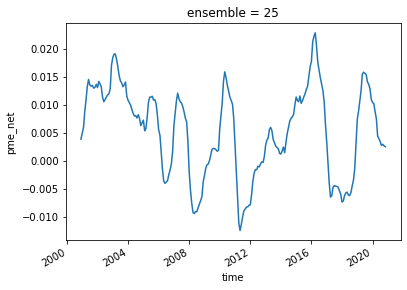

In [15]:
(pme_ts*1e3).rolling(time=12).mean().plot()
pme_ts_anom=(pme_ts-pme_ts.values[0])*1e3
print(pme_ts_anom.values[-1])
print(pme_ts.mean().values*1e3)
print(pme_ts.std().values*1e3)

# There is 5.2Sv into the Box ????
# NEed to correc this to years. 

In [16]:
# SSH
ssh=phys_eqpac.eta_t.sel(ensemble=25).sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-5,5)).load()

In [17]:
ssh

<xarray.DataArray 'eta_t' (time: 241, lat: 30, lon: 170)>
array([[[0.79089195, 0.79263115,        nan, ...,        nan,
                nan,        nan],
        [0.7876736 , 0.7931739 ,        nan, ...,        nan,
                nan,        nan],
        [0.7923825 , 0.78773993,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.7499977 , 0.73961455, 0.73509014, ...,        nan,
                nan,        nan],
        [0.7415547 , 0.7311845 , 0.7278147 , ...,        nan,
                nan,        nan],
        [0.7342407 , 0.7238057 , 0.72150457, ...,        nan,
                nan,        nan]],

       [[0.81959695, 0.81503946,        nan, ...,        nan,
                nan,        nan],
        [0.8125169 , 0.8116544 ,        nan, ...,        nan,
                nan,        nan],
        [0.8119656 , 0.8065076 ,        nan, ...,        nan,
                nan,        nan],
...
        [0.7297825 , 0.7151985 , 0.7086706 , ...,        nan,
                nan,        nan],
        [0.73003733, 0.7122052 , 0.70503604, ...,        nan,
                nan,        nan],
        [0.7297678 , 0.710048  , 0.7014573 , ...,        nan,
                nan,        nan]],

       [[0.7144465 , 0.7143813 ,        nan, ...,        nan,
                nan,        nan],
        [0.7114447 , 0.7142917 ,        nan, ...,        nan,
                nan,        nan],
        [0.71245545, 0.71288985,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.69962686, 0.6895224 , 0.6839436 , ...,        nan,
                nan,        nan],
        [0.698288  , 0.68686205, 0.68145496, ...,        nan,
                nan,        nan],
        [0.69510263, 0.68505603, 0.67851317, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -4.833 -4.5 -4.166 -3.834 ... 3.834 4.166 4.5 4.833
Attributes:
    cell_methods:  time: mean
    long_name:     surface height on T cells [Boussinesq (volume conserving) ...
    units:         meter
    valid_range:   [-20.0, 20.0]

0.07402274
0.40060887


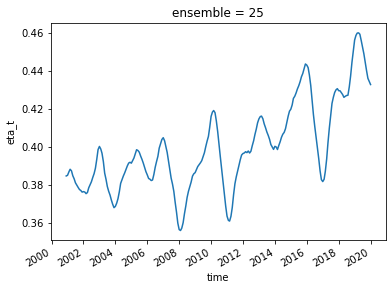

In [18]:
ssh_ts=ssh.mean(['lat','lon'])
ssh_ts_anom=(ssh_ts-ssh_ts.values[0])#*1e6
print(ssh_ts_anom.values[-1])
print(ssh_ts.mean().values)
(ssh_ts).rolling(time=12).mean().plot()

In [19]:
extras=False
if extras==True:
    temp_tx=phys_eqpac.sel(lat=5,ensemble=25,method='nearest').sel(time=slice('2000-01-01','2020-01-01'))[['neutral_diffusion_temp','temp_vdiff_impl', 'neutral_gm_temp','temp_sponge_tend']]
    temp_tx_loaded=temp_tx.mean(dim='time').load()

    plt.subplot(221)
    temp_tx_loaded.neutral_diffusion_temp.plot()
    plt.ylim([1000,0])
    plt.subplot(222)
    temp_tx_loaded.temp_vdiff_impl.plot()
    plt.ylim([1000,0])
    plt.subplot(223)
    temp_tx_loaded.neutral_gm_temp.plot()
    plt.ylim([1000,0])
    plt.subplot(224)
    temp_tx_loaded.temp_sponge_tend.plot()
    plt.ylim([1000,0])
    plt.tight_layout()
    plt.show()

    # Mean at 5S 2000-2020
    print(temp_tx_loaded.neutral_diffusion_temp.mean().values)
    print(temp_tx_loaded.temp_vdiff_impl.mean().values)
    print(temp_tx_loaded.neutral_gm_temp.mean().values)
    print(temp_tx_loaded.temp_sponge_tend.mean().values)

In [20]:
# RUN SAVE RICHARDSS CALCS

#import xarray as xr
#from dask_jobqueue import PBSCluster
#from dask.distributed import Client
#import numpy as np
#import xrft
import scipy
#import matplotlib.pyplot as plt
import datetime
#import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
#%config Completer.use_jedi = False

#from eofs.xarray import Eof


# in the OOD cluster



def load_richard_transports_CAFE60(ens=24,t1 = '1980-01-01',
                                    t2 = '2020-12-31',
                                    x1=-240, x2=-60,
                                    y1=-7, y2=7):

    file1='/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip'
    file2='/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'
    file4='/g/data/xv83/dcfp/CAFE60v1/ocean_daily.zarr.zip'
    file3='/home/mat236/area.nc'

    #dgrid=xr.open_dataset(file1)
    docn = xr.open_zarr(file1,consolidated=True)
    #darea= xr.open_dataset('/g/data/xv83/rxm599/area.nc')
    darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
    #darea

    dbgc = xr.open_zarr(file2)

    darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
    darea

    # create a thickness variable on the tracer depth grid
    mdepth=docn.st_ocean.copy()
    dbot=np.copy(docn.sw_ocean)
    dthick=dbot*0
    dthick[1:50]=dbot[1:50]-dbot[0:49]

    dthick[0]=dbot[0]
    #print(dthick,dbot)
    mdepth=mdepth*0+dthick
    mdepth


    adic=dbgc.adic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    dic=dbgc.dic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    aco2=adic-dic




    cthickness=mdepth
    cthickness
    omask=(aco2[-1,0,:,:]*0).copy()
    cinv = aco2*cthickness*1e-3 #mmol to mols

    mcinv600=cinv.sel(st_ocean=slice(0,600)).sum(axis=1)+omask
    mcinv300=cinv.sel(st_ocean=slice(0,300)).sum(axis=1)+omask
    mcinv1000=cinv.sel(st_ocean=slice(0,1000)).sum(axis=1)+omask
    mcinv=cinv.sum(axis=1)+omask


    # RUN AND SAVE RICHARD TRANSPORTS


    vt=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2)).sel(yu_ocean=y1,method='nearest')

    tv=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
    tv_gm_i=docn.ty_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
    tu=docn.tx_trans[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    tu_gm_i=docn.tx_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))


    tv_gm=tv_gm_i-tv_gm_i.shift(st_ocean=-1)

    # need to rename axis to work !! aco2_face=aco2.interp_like(tv)
    aco2_face=aco2.interp(yt_ocean=tv.yu_ocean)

    aco2_face


    trans_aco2 = aco2_face*tv
    trans_aco2_gm = aco2_face*tv_gm

    # CALC TU AS WELL AS TV

    tu_gm=tu_gm_i-tu_gm_i.shift(st_ocean=-1)
    aco2_face_u=aco2.interp(xt_ocean=tu.xu_ocean)
    trans_aco2_u = aco2_face_u*tu
    trans_aco2_u_gm = aco2_face_u*tu_gm


    direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
    print('saving tv')
    tv.to_netcdf(direc+'trans_v.nc')
    print('saving tv co2')
    trans_aco2.to_netcdf(direc+'trans_aco2_v.nc')
    print('saving tv co2 gm')
    trans_aco2_gm.to_netcdf(direc+'trans_aco2_v_gm.nc')
    print('saving tu')
    tu.to_netcdf(direc+'trans_u.nc')
    print('saving tu co2')
    trans_aco2_u.to_netcdf(direc+'trans_aco2_u.nc')
    print('saving tu co2_gm')
    trans_aco2_u_gm.to_netcdf(direc+'trans_aco2_u_gm.nc')


def load_richard_transports_CAFE60_2(ens=24,t1 = '1980-01-01',
                                    t2 = '2020-12-31',
                                    x1=-240, x2=-60,
                                    y1=-40.5, y2=40.5):

    file1='/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip'
    file2='/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'
    file4='/g/data/xv83/dcfp/CAFE60v1/ocean_daily.zarr.zip'
    file3='/home/mat236/area.nc'

    #dgrid=xr.open_dataset(file1)
    docn = xr.open_zarr(file1,consolidated=True)
    #darea= xr.open_dataset('/g/data/xv83/rxm599/area.nc')
    darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
    #darea

    dbgc = xr.open_zarr(file2)

    darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
    darea

    # create a thickness variable on the tracer depth grid
    mdepth=docn.st_ocean.copy()
    dbot=np.copy(docn.sw_ocean)
    dthick=dbot*0
    dthick[1:50]=dbot[1:50]-dbot[0:49]

    dthick[0]=dbot[0]
    #print(dthick,dbot)
    mdepth=mdepth*0+dthick
    mdepth


    adic=dbgc.adic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    dic=dbgc.dic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    aco2=adic-dic




    cthickness=mdepth
    cthickness
    omask=(aco2[-1,0,:,:]*0).copy()
    cinv = aco2*cthickness*1e-3 #mmol to mols

    mcinv600=cinv.sel(st_ocean=slice(0,600)).sum(axis=1)+omask
    mcinv300=cinv.sel(st_ocean=slice(0,300)).sum(axis=1)+omask
    mcinv1000=cinv.sel(st_ocean=slice(0,1000)).sum(axis=1)+omask
    mcinv=cinv.sum(axis=1)+omask


    # RUN AND SAVE RICHARD TRANSPORTS


    vt=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2)).sel(yu_ocean=y1,method='nearest')

    tv=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
    tv_gm_i=docn.ty_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
    tu=docn.tx_trans[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    tu_gm_i=docn.tx_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))


    tv_gm=tv_gm_i-tv_gm_i.shift(st_ocean=-1)

    # need to rename axis to work !! aco2_face=aco2.interp_like(tv)
    aco2_face=aco2.interp(yt_ocean=tv.yu_ocean)

    aco2_face


    trans_aco2 = aco2_face*tv
    trans_aco2_gm = aco2_face*tv_gm

    # CALC TU AS WELL AS TV

    tu_gm=tu_gm_i-tu_gm_i.shift(st_ocean=-1)
    aco2_face_u=aco2.interp(xt_ocean=tu.xu_ocean)
    trans_aco2_u = aco2_face_u*tu
    trans_aco2_u_gm = aco2_face_u*tu_gm


    direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
    print('saving tv')
    tv.sel(st_ocean=slice(0,400)).to_netcdf(direc+'trans_v_400.nc')
    print('saving tv co2')
    #trans_aco2.sel(st_ocean=slice(0,400)).to_netcdf(direc+'trans_aco2_v_400.nc')
    print('saving tv co2 gm')
    #trans_aco2_gm.sel(st_ocean=slice(0,400)).to_netcdf(direc+'trans_aco2_v_gm_400.nc')
    print('saving tu')
    #tu.to_netcdf(direc+'trans_u.nc')
    print('saving tu co2')
    #trans_aco2_u.sel(st_ocean=slice(0,400)).to_netcdf(direc+'trans_aco2_u_400.nc')
    print('saving tu co2_gm')
    #trans_aco2_u_gm.sel(st_ocean=slice(0,400)).to_netcdf(direc+'trans_aco2_u_gm_400.nc')



In [21]:
cluster#.close()

In [22]:
save_richard_numbers=False
save_richard_numbers1=False
if save_richard_numbers==True:
    load_richard_transports_CAFE60()
    
if save_richard_numbers1==True:
    load_richard_transports_CAFE60_2()

In [23]:
gr=xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
gr=gr[['ds_00_02_T','ds_20_22_T','ds_02_22_T','ds_00_20_T']]
gr=gr.rename({'grid_x_T':'lon','grid_y_T':'lat'})
gr['lon']=gr['lon']+360
gr_slice=gr.sel(lon=slice(120,290),lat=slice(-40,40))#
lon_face_length_m=gr_slice.ds_00_02_T
lat_face_length_m=gr_slice.ds_20_22_T

In [24]:
# Areas and grid depths

adic=(eqpac.sel(ensemble=25)[['dic','adic']])
area=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area['xt_ocean']=area['xt_ocean']+360
area['xu_ocean']=area['xu_ocean']+360
area_m2=area.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})

st_ocean_holder=adic.st_ocean
l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)
    
st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))

In [25]:
area_m2

<xarray.DataArray 'area_t' (lat: 140, lon: 170)>
array([[9.285778e+09, 9.285778e+09, 9.285778e+09, ..., 9.285778e+09,
        9.285778e+09, 9.285778e+09],
       [9.467707e+09, 9.467707e+09, 9.467707e+09, ..., 9.467707e+09,
        9.467707e+09, 9.467707e+09],
       [9.643206e+09, 9.643206e+09, 9.643206e+09, ..., 9.643206e+09,
        9.643206e+09, 9.643206e+09],
       ...,
       [9.505625e+09, 9.505625e+09, 9.505625e+09, ..., 9.505625e+09,
        9.505625e+09, 9.505625e+09],
       [9.296072e+09, 9.296072e+09, 9.296072e+09, ..., 9.296072e+09,
        9.296072e+09, 9.296072e+09],
       [9.077938e+09, 9.077938e+09, 9.077938e+09, ..., 9.077938e+09,
        9.077938e+09, 9.077938e+09]], dtype=float32)
Coordinates:
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    long_name:  tracer cell area
    units:      m^2
    history:    From ocean_month_1500_01

In [26]:
adic

,Array,Chunk
Bytes,3.24 GiB,278.91 kiB
Shape,"(731, 50, 140, 170)","(1, 3, 140, 170)"
Count,37282 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.24 GiB,278.91 kiB
Shape,"(731, 50, 140, 170)","(1, 3, 140, 170)"
Count,37282 Tasks,12427 Chunks
Type,float32,numpy.ndarray


In [27]:
cluster

In [ ]:
# Calc Canth Accumulation
raw_carbon_1980=adic.sel(time=slice('1980-01-01','2020-01-01'),lat=slice(-6,6)).load() #CHECK LOAD
raw_carbon=raw_carbon_1980.sel(time=slice('2000-01-01','2020-01-01'))
raw_carbon_area=raw_carbon*area_m2*st_ocean_holder.depth_diff
anth_c_area=raw_carbon_area.adic-raw_carbon_area.dic
raw_carbon_area_1980=raw_carbon_1980*area_m2*st_ocean_holder.depth_diff
anth_c_area_1980=raw_carbon_area_1980.adic-raw_carbon_area_1980.dic
print('loaded1')

raw_anth_c=raw_carbon.adic-raw_carbon.dic
raw_anth_c_1980=raw_carbon_1980.adic-raw_carbon_1980.dic

In [ ]:
# Calc Canth Accumulation
raw_carbon_large=adic.sel(time=slice('1980-01-01','2020-01-01'),lat=slice(-40.5,40.5),st_ocean=slice(0,400)).load() #CHECK LOAD
#raw_carbon_large=raw_carbon_large.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-40.5,40.5),st_ocean=slice(0,400))#.load() #CHECK LOAD
raw_anth_c_large=raw_carbon_large.adic-raw_carbon_large.dic
#raw_anth_c_large_1980=raw_carbon_large_1980.adic-raw_carbon_large.dic

#raw_carbon_area_large=raw_carbon_large*area_m2*st_ocean_holder.sel(st_ocean=slice(0,400)).depth_diff
#anth_c_area_large=raw_carbon_area_largeadic-raw_carbon_area_large.dic
#anth_c_area     #mmol m3
anth_c_area     #mmol m3

In [ ]:
# Calc Canth CO2 flux
adic_co2flux=(eqpac.sel(ensemble=25)['stf10']-eqpac.sel(ensemble=25)['stf07']).sel(lat=slice(-5,5),time=slice('1980-01-01','2020-01-01'))
adic_co2flux_area=adic_co2flux*area_m2
adic_co2flux_area_loaded=adic_co2flux_area.load()
co2=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18
co2_seasonal=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18

In [ ]:
co2_80=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('1980','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18

In [ ]:
co2=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18
co2_rolling=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18

In [ ]:
co2=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18

In [ ]:
(co2.cumsum()/12).plot()
(((anth_c_area-anth_c_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot()
(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot()
plt.legend(['Co2 flux accumulation','Full depth accumulation','300m accumulation'])

In [ ]:
# Ok Now lets sort out our transports

In [ ]:
#adic_concentrations.sel(lon=120,method='nearest').interp(lat=tu.lat)
# We need to do the conversion AND rename the cols and possibly fix the lons to same coord system.
# * 1e6 *1e-15*12*1e-3 * 86400 *365
def fix_xuyu(dat):
    try:
        dat=dat.rename({'xu_ocean':'lon','yu_ocean':'lat'})
        print('renamed')
    except:
        pass
    try:
        dat=dat.rename({'xt_ocean':'lon','yu_ocean':'lat'})
        print('renamed')
    except:
        pass
    try:
        dat=dat.rename({'xt_ocean':'lon','yt_ocean':'lat'})
        print('renamed')
    except:
        pass
    try:
        dat=dat.rename({'xu_ocean':'lon','yt_ocean':'lat'})
        print('renamed')
    except:
        pass 
    try:
        dat=dat.rename({'xu_ocean':'lon'})
        print('renamed')
    except:
        pass 
    
    dat['time']=dat.time.astype('datetime64[M]')

    dat['lon']=dat['lon']+360
    #dat['lon_x']=dat['lon_x']+360
    return dat

In [ ]:
# RICHARDS NUMBERS??? Overwrite so we can do a test. Need to do conversion though??
direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
tv=xr.open_dataset(direc+'trans_v.nc').ty_trans.chunk('auto')
tv_400=xr.open_dataset(direc+'trans_v_400.nc').ty_trans.chunk('auto')

tv_canth=xr.open_dataset(direc+'trans_aco2_v.nc').__xarray_dataarray_variable__.chunk('auto')
tv_canth_gm=xr.open_dataset(direc+'trans_aco2_v_gm.nc').__xarray_dataarray_variable__.chunk('auto')

tv_canth_400=xr.open_dataset(direc+'trans_aco2_v_400.nc').__xarray_dataarray_variable__.chunk('auto')
tv_canth_gm_400=xr.open_dataset(direc+'trans_aco2_v_gm_400.nc').__xarray_dataarray_variable__.chunk('auto')

tu=xr.open_dataset(direc+'trans_u.nc').tx_trans.chunk('auto')
tu_canth=xr.open_dataset(direc+'trans_aco2_u.nc').__xarray_dataarray_variable__.chunk('auto')
tu_canth_gm=xr.open_dataset(direc+'trans_aco2_u_gm.nc').__xarray_dataarray_variable__.chunk('auto')


tu=fix_xuyu(tu)
tu_canth=fix_xuyu(tu_canth).sel(xu_ocean=-239.5,method='nearest')* 1e6 *1e-15*12*1e-3 * 86400 *365
tu_canth_gm=fix_xuyu(tu_canth_gm).sel(xu_ocean=-239.5,method='nearest')* 1e6 *1e-15*12*1e-3 * 86400 *365


tv=fix_xuyu(tv)
tv_400=fix_xuyu(tv_400)
tv_canth=fix_xuyu(tv_canth)* 1e6 *1e-15*12*1e-3 * 86400 *365
tv_canth_gm=fix_xuyu(tv_canth_gm)* 1e6 *1e-15*12*1e-3 * 86400 *365

tv_canth_400=fix_xuyu(tv_canth_400)* 1e6 *1e-15*12*1e-3 * 86400 *365
tv_canth_gm_400=fix_xuyu(tv_canth_gm_400)* 1e6 *1e-15*12*1e-3 * 86400 *365

In [ ]:
#_canth

In [ ]:
# QUICK FACE TESTS

In [ ]:
N_face_tx=tv_canth.sel(lat=5,method='nearest')
N_face_tx_3=tv_canth.sel(lat=3,method='nearest')
N_face_tx_gm=tv_canth_gm.sel(lat=5,method='nearest')
N_face_tx_3_gm=tv_canth_gm.sel(lat=3,method='nearest')

S_face_tx=tv_canth.sel(lat=-5,method='nearest')
S_face_tx_3=tv_canth.sel(lat=-3,method='nearest')
S_face_tx_gm=tv_canth_gm.sel(lat=-5,method='nearest')
S_face_tx_3_gm=tv_canth_gm.sel(lat=-3,method='nearest')

S_face_tx_small=tv_canth.sel(lon=slice(145,300)).sel(lat=-5,method='nearest')
S_face_tx_gm_small=tv_canth_gm.sel(lon=slice(145,300)).sel(lat=-5,method='nearest')

E_face_tx=tu_canth
E_face_tx_gm=tu_canth_gm

In [ ]:
ntx=-N_face_tx.sum(['lon','st_ocean'])
stx=S_face_tx.sum(['lon','st_ocean'])
stx_small=S_face_tx_small.sum(['lon','st_ocean'])

etx=E_face_tx.sum(['lat','st_ocean'])

ntx_gm=-N_face_tx_gm.sum(['lon','st_ocean'])
stx_gm=S_face_tx_gm.sum(['lon','st_ocean'])
stx_gm_small=S_face_tx_gm_small.sum(['lon','st_ocean'])

etx_gm=E_face_tx_gm.sum(['lat','st_ocean'])


itf_canth=(tu_canth.sum(['st_ocean','lat'])+tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_canth_gm=(tu_canth_gm.sum(['st_ocean','lat'])+tv_canth_gm.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

In [ ]:
(tu_canth.sum(['st_ocean','lat']))* 1e6 *1e-15*12*1e-3 * 86400 *365

In [ ]:
# \ ACCUMULATION FIGURE #((ntx+stx+etx).cumsum()/12).plot() #* 1e6 *1e-18*12*86400 *365
plt.figure(figsize=(10,5))
((ntx+ntx_gm).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot(c='k')
#((-(ntx+ntx_gm+stx+stx_gm+etx+etx_gm+co2)).cumsum()/12).plot(c='k',linestyle=':')
((stx_small+stx_gm_small).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot(linestyle=':',c='m')
((((etx+etx_gm))).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot()
((co2).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot()
((itf_canth+itf_canth_gm).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot()
#((ntx+ntx_gm+stx+stx_gm+etx+etx_gm).cumsum()/12).plot()

#((ntx+stx+etx+co2).cumsum()/12).plot
#((ntx+stx+etx+co2).cumsum()/12).plot()
#((ntx+ntx_gm+stx+stx_gm+etx+etx_gm).cumsum()/12).plot()

#(((anth_c_area-anth_c_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r')
#(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r',linestyle=':')
plt.legend(['N','S','E','CO2','ITF'])

In [ ]:
cluster#.close()

In [ ]:
# \ ACCUMULATION FIGURE PLOT FIGURE #((ntx+stx+etx).cumsum()/12).plot() #* 1e6 *1e-18*12*86400 *365
plt.figure(figsize=(10,5))
(((((ntx+ntx_gm+stx+stx_gm+etx+etx_gm))+co2)).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot(c='k')
#((-(ntx+ntx_gm+stx+stx_gm+etx+etx_gm+co2)).cumsum()/12).plot(c='k',linestyle=':')
((((ntx+ntx_gm+stx_small+stx_gm_small+itf_canth+itf_canth_gm))+co2).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot(linestyle=':',c='m')
(((((ntx+ntx_gm+stx+stx_gm+etx+etx_gm+(co2*2.5))))).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot(c='cyan')
(((((ntx+ntx_gm+stx+stx_gm))+co2)).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot()
((((stx+stx_gm+etx+etx_gm))+co2).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot()
#((ntx+ntx_gm+stx+stx_gm+etx+etx_gm).cumsum()/12).plot()

#((ntx+stx+etx+co2).cumsum()/12).plot
#((ntx+stx+etx+co2).cumsum()/12).plot()
#((ntx+ntx_gm+stx+stx_gm+etx+etx_gm).cumsum()/12).plot()

(((anth_c_area-anth_c_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r')
(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r',linestyle=':')
plt.legend(['N+S+E gm+Co2 flux','Real ITF method','2.5x Co2 flux', 'No E Flow','No N Flow','Full depth accumulation','300m accumulation'])

In [ ]:
#trans_aco2[:,:,0,:]#.sum(axis=(1,2))#.compute()

In [ ]:
# RICHARDS NUMBERS??? Overwrite so we can do a test. Need to do conversion though??
#direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
#tv_r=xr.open_dataset(direc+'trans_v.nc').ty_trans
#trans_aco2=xr.open_dataset(direc+'trans_aco2_v.nc').__xarray_dataarray_variable__
#trans_aco2_gm=xr.open_dataset(direc+'trans_aco2_v_gm.nc').__xarray_dataarray_variable__

#tu=xr.open_dataset(direc+'trans_u.nc').tx_trans
#tu_canth=xr.open_dataset(direc+'trans_aco2_u.nc').__xarray_dataarray_variable__
#tu_canth_gm=xr.open_dataset(direc+'trans_aco2_u_gm.nc').__xarray_dataarray_variable__

#trans_s_gm=trans_aco2_gm[:,:,0,:].sum(axis=(1,2)).compute()
#trans_n_gm=trans_aco2_gm[:,:,28,:].sum(axis=(1,2)).compute()
#trans_s=trans_aco2[:,:,0,:].sum(axis=(1,2)).compute()
#trans_n=trans_aco2[:,:,28,:].sum(axis=(1,2)).compute()

#mtrans_s=tv[:,:,0,:].sum(axis=(1,2)).compute()
#mtrans_n=tv[:,:,28,:].sum(axis=(1,2)).compute()

#trans_s_gm_300=trans_aco2_gm[:,0:24,0,:].sum(axis=(1,2)).compute()
#trans_n_gm_300=trans_aco2_gm[:,0:24,28,:].sum(axis=(1,2)).compute()
#trans_s_300=trans_aco2[:,0:24,0,:].sum(axis=(1,2)).compute()
#trans_n_300=trans_aco2[:,0:24,28,:].sum(axis=(1,2)).compute()

#mtrans_s_300=tv[:,0:24,0,:].sum(axis=(1,2)).compute()
#mtrans_n_300=tv[:,0:24,28,:].sum(axis=(1,2)).compute()


#print(trans_s_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
#print(trans_s_gm_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
#print(trans_n_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
#print(trans_n_gm_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)

#print(mtrans_s_300.mean(axis=0).values )
#print(mtrans_n_300.mean(axis=0).values )
#print('\n')
#print(trans_s.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
#print(trans_s_gm.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
#print(trans_n.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
#print(trans_n_gm.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)

#print(mtrans_s.mean(axis=0).values )
#print(mtrans_n.mean(axis=0).values )

In [ ]:
#print((tv_canth.sel(lat=-4.7,method='nearest').sum(['lon','st_ocean'])* 1e6 *1e-15*12*1e-3 * 86400 *365).mean().values)
#print((tv_canth.sel(lat=4.7,method='nearest').sum(['lon','st_ocean'])*1e6 *1e-15*12*1e-3 * 86400 *365).mean().values)

#print(((tv_canth+tv_canth_gm).sel(lat=-4.7,method='nearest').sum(['lon','st_ocean'])* 1e6 *1e-15*12*1e-3 * 86400 *365).mean().values)
#print(((tv_canth+tv_canth_gm).sel(lat=4.7,method='nearest').sum(['lon','st_ocean'])*1e6 *1e-15*12*1e-3 * 86400 *365).mean().values)

#print(tv_canth.sel(lat=-4.7,method='nearest').sum(['lon','st_ocean']).mean().values)
#print(tv_canth.sel(lat=4.7,method='nearest').sum(['lon','st_ocean']).mean().values)

#print(trans_aco2[:,:,0,:].sum(axis=(1,2)).mean().values* 1e6 *1e-15*12*1e-3 * 86400 *365)
#print(tv_canth.sel(lat=-4.7,method='nearest').sum(['lon','st_ocean']).mean().values* 1e6 *1e-15*12*1e-3 * 86400 *365)

#print(trans_aco2[:,:,28,:].sum(axis=(1,2)).mean().values* 1e6 *1e-15*12*1e-3 * 86400 *365)
#print(tv_canth.sel(lat=4.7,method='nearest').sum(['lon','st_ocean']).mean().values* 1e6 *1e-15*12*1e-3 * 86400 *365)

In [ ]:
def plot_cartopy_row(dat,
                     axn,
                     sb1=2,
                     sb2=2,
                     levs=None,
                     lon='lon',lat='lat',title=None,cmap='RdBu_r',extend=None,units=''):
                     
    usemap_proj = ccrs.PlateCarree(central_longitude=180)
    usemap_proj._threshold /= 20.  # to make greatcircle smooth

    fr=0.03
    fs=12
    ms=10
    
    
    ax = plt.subplot(sb1,sb2,axn,projection=usemap_proj)
    
    ax.set_extent([120, 290, -40, 40], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    f=ax.contourf(dat[lon].values,dat[lat].values,dat,transform=ccrs.PlateCarree(),cmap=cmap,levels=levs,extend=extend) 
        #Quick anti-aliasing fix as per: https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps
    for c in f.collections:
        c.set_edgecolor("face")
    
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.axhline(5,c='k')
    ax.axhline(-5,c='k')
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
    ax.set_title(title)
    #Colorbar
    cb=plt.colorbar(f,ax=ax,fraction=fr)
    cb.set_label(units,fontsize=fs)
    cb.ax.tick_params(labelsize=fs-1)

In [ ]:
# LOAD ENSO

#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon


def add_enso_colours(ax):
    #Put in the ENSO box regions
    #ep_events and cp events
    import matplotlib.patches as patches
    #ensofps=['../processed_data/indexes/el_nino_events.csv','../processed_data//indexes/la_nina_events.csv']
    #ensofps=['../processed_data//indexes/el_nino_events.csv','../processed_data//indexes/la_nina_events.csv','../processed_data//indexes/cp_events.csv','../processed_data//indexes/cold_cp_events.csv']
    #ensofps=['../processed_data//indexes/ep_events.csv','../processed_data//indexes/la_nina_events.csv','../processed_data//indexes/cp_events.csv']
    ensofps=['../processed_data/indexes/ep_events_ch2.csv','../processed_data/indexes/la_nina_events_ch2.csv','../processed_data/indexes/cp_events_ch2.csv']
   
    for whichenso,fp in enumerate(ensofps):
        events=pd.read_csv(fp)
        for ev in events.iterrows():
            endm=np.datetime64(ev[1].end).astype('datetime64[M]')
            endm1=endm-np.timedelta64(1,'M')
            endm2=endm+np.timedelta64(1,'M')
            start=np.datetime64(ev[1].start).astype('datetime64[M]')
          
            if start==endm1: #We don't want to plot events that last for only a month
                pass    
            #elif start==endm2-np.timedelta64(1,'M'): #There was some weirdness with the 2015 event not being continuous, and this fixes it..,
            #    pass
            else:
                if whichenso==0:
                    #if el nino
                    patchcol='darkred'#'firebrick'
                elif whichenso==1:
                    #if la nina
                    patchcol='deepskyblue'
                elif whichenso==2:
                    patchcol='darkorange'
                elif whichenso==3:
                    patchcol='navy'
                rect=patches.Rectangle((start,-25),endm-start,50,linewidth=0,alpha=0.3,color=patchcol)
                ax.add_patch(rect)
                rect=patches.Rectangle((start,-25),endm-start,50,linewidth=0,alpha=0.3,color=patchcol)
                ax.add_patch(rect)
    return True

In [ ]:
# Need to trim or shorten
def linear_trend(ax,x,y):#,xlab,ylab,diagonal_line=1,printer=1,plot=1,logspace=0,color=np.ndarray(0),zx=np.ndarray(0),zy=np.ndarray(0),trendline=1):
    """"
    Designed for chlorophyll trends <1mg/m3 
    
    Given an x and y (same size)
    + Title, X Label, Y Label
    
    if Z, will plot 
    Optional: Diagonal_line=0, default on.
    Optional: Printer=0, default on
    
    Returns linear statistics. 
    """
    
    x1=np.ravel(x)
    y=np.ravel(y)
    mask=~np.isnan(x1)
    x=x[mask]
    y=y[mask]
    x2=x1.astype('datetime64[D]')
    slope, intercept, r_value, p_value, std_err = linregress(pd.to_numeric(x2),y)
    #if plot==0:
    #     return slope, intercept, r_value, p_value, std_err 
    
    mn=min(pd.to_numeric(x2))
    mx=max(pd.to_numeric(x2))
    x2=np.linspace(mn,mx,len(x2))
    y1=slope*pd.to_numeric(x2)+intercept
    plt.plot(x,y1,'r:',linewidth=2)  
     
    return slope, intercept, r_value, p_value

In [ ]:
# CALCULATE TABLE
# For Table also need CO2 flux and Accumulation rates / yr

In [ ]:
# TABLE?
# Load Regions? 

# CHECK WHICH VARS INPUT!
varz_mean=[tv,
           tv_canth,
           (tv_canth+tv_canth_gm)]

region_mask=xr.open_dataset('new_calculations/region_mask_new.nc').sortby('lat') #region_mask_may12
region_mask['st_ocean']=region_mask['st_ocean']*-1
region_mask=region_mask.load()
region_mask#.close()#mask['st_ocean']=mask.st_ocean*-1 # mask will need a bit of fixing (where =1)

# TABLE?
ev=[None,neutral_events,ep_events,cp_events,nina_events]
evName=['Alltime','Neutral','EP','CP','La Nina']

In [ ]:
#method='std' # or mean
region_mask['south_wbc_subsurface']=xr.concat([region_mask.south_wbc,region_mask.south_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['north_wbc_subsurface']=xr.concat([region_mask.north_wbc,region_mask.north_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['south_shallowwbc_subsurface']=xr.concat([region_mask.shallow_south_wbc,region_mask.south_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['north_shallowwbc_subsurface']=xr.concat([region_mask.shallow_north_wbc,region_mask.north_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()

In [ ]:
masksN=[region_mask.north_subsurface,region_mask.north_surface,region_mask.north_wbc,region_mask.shallow_north_wbc,region_mask.north_wbc_subsurface,region_mask.north_shallowwbc_subsurface,region_mask.above_isopycnal,None]#,None,None]
masksS=[region_mask.south_subsurface,region_mask.south_surface,region_mask.south_wbc,region_mask.shallow_south_wbc,region_mask.south_wbc_subsurface,region_mask.south_shallowwbc_subsurface,region_mask.above_isopycnal,None]#,None,None]
direction=[5,-5,'convergence']
dir_names=['5N','5S','Convergence']
mask_names=['Subsurface','Surface','WBC','ShallowWBC','WBC+Interior','ShallowWBC+Interior','Above Isotherm','Full Depth']#'positive','negative']

varz=varz_mean
method='mean' #'total #Syn #std
var_names=['Meridional Transport','AnthC transport','AnthC+GM transport']#,'C transport','adic','adic_accumulation']

In [ ]:
#tv
depth_reg_1=region_mask.south_surface.sel(lat=-5,method='nearest')
depth_reg_2=region_mask.north_surface.sel(lat=5,method='nearest')

print((tv.sel(lat=-5,method='nearest').where(depth_reg_1==1).sum(dim=['st_ocean','lon'])+-tv.sel(lat=5,method='nearest').where(depth_reg_2==1).sum(dim=['st_ocean','lon'])).mean(dim='time').values)
print((tv.sel(lat=-5,method='nearest').where(depth_reg_1==1).sum(dim=['st_ocean','lon'])+-tv.sel(lat=5,method='nearest').where(depth_reg_2==1).sum(dim=['st_ocean','lon'])).std(dim='time').values)
print((tv.sel(lat=-5,method='nearest').where(depth_reg_1==1).sum(dim=['st_ocean','lon']).mean(dim='time').values)+-tv.sel(lat=5,method='nearest').where(depth_reg_2==1).sum(dim=['st_ocean','lon']).mean(dim='time').values)
print((tv.sel(lat=-5,method='nearest').where(depth_reg_1==1).sum(dim=['st_ocean','lon']).std(dim='time').values)+-tv.sel(lat=5,method='nearest').where(depth_reg_2==1).sum(dim=['st_ocean','lon']).std(dim='time').values)


In [ ]:
cluster

In [ ]:
#masksS

In [ ]:
run_table=False
if run_table==True
    for method in ['std','mean','trend','rollingtrend']:
        df_holder=[]
        for iENSO,enso_dates in enumerate(ev):
            enso_name=evName[iENSO]
            for var_i,data_type in enumerate(varz):

                data_type=data_type.sel(time=slice('2000','2020'))
                if enso_dates is not None:
                    data_type=data_type.sel(time=enso_dates)


                df_row_holder=[]
                for i,NS in enumerate(direction):
                    assert(len(masksN)==len(masksS)) # TEST TO MAKE SURE NO ISSUE. Only keen on index can manually do it later
                    mask_holder=masksN    
                    for depth_i,depth_region in enumerate(mask_holder):

                        data_type_s=data_type.sel(lon=slice(145,300)) 
                        if i==0: # North
                            #mask_holder=masksN
                            #data_type=data_type*-1
                            d=-data_type.sel(lat=NS,method='nearest').sum(dim=['st_ocean','lon'])

                        elif i==1: # South
                            #mask_holder=masksS
                            # REMOVE ITF FROM S FACE
                            d=data_type_s.sel(lat=NS,method='nearest').sum(dim=['st_ocean','lon'])
                        elif i==2: #convergence
                            d=(data_type_s.sel(lat=direction[1],method='nearest').sum(dim=['st_ocean','lon'])+\
                                -data_type.sel(lat=direction[0],method='nearest').sum(dim=['st_ocean','lon']))


                        var_name=var_names[var_i]
                        depth_name=mask_names[depth_i]
                        direction_name = dir_names[i]



                        if depth_name=='Full Depth':
                            if method=='mean':
                                ans=d.mean(dim='time').values
                            elif method=='std':
                                ans=d.std(dim='time').values
                            elif method=='trend':
                                 ans=xarray_get_trend(d.chunk(dict(time=-1))).sel(parameter=0).values        
                            elif method=='rollingtrend':
                                ans=xarray_rolling_trends(d.chunk(dict(time=-1))).mean(dim='timeperiod').values


                            #elif method=='sum':
                            #    d=data_type.sel(lat=NS,method='nearest').sum(dim='time').sum().values


                        if mask_holder[depth_i] is not None:
                            depth_reg_s=masksS[depth_i].sel(lat=-5,method='nearest')        
                            depth_reg_n=masksN[depth_i].sel(lat=5,method='nearest')      

                            if i==2:#'convergence':    #convergence 
                                #if depth_name=='Surface':
                                #    breakkkkkkkk
                                d1=(data_type_s.sel(lat=-5,method='nearest').where(depth_reg_s==1).sum(dim=['st_ocean','lon'])+\
                                    -data_type.sel(lat=5,method='nearest').where(depth_reg_n==1).sum(dim=['st_ocean','lon']))

                            elif i==1:#:NS==-5:
                                d1=data_type_s.sel(lat=NS,method='nearest').where(depth_reg_s==1).sum(dim=['st_ocean','lon'])
                            elif i==0:#NS==5:
                                d1=-data_type.sel(lat=NS,method='nearest').where(depth_reg_n==1).sum(dim=['st_ocean','lon'])


                            if method=='mean': 
                                ans=d1.mean(dim='time').values

                                #if depth_name=='WBC+Interior':
                                #    brekkkknow
                            elif method=='std': 
                                ans=d1.std(dim='time').values
                            elif method=='trend':
                                # DO TREND
                                ans=xarray_get_trend(d1.chunk(dict(time=-1))).sel(parameter=0).values
                            elif method=='rollingtrend':
                                # DO TREND
                                ans=xarray_rolling_trends(d1.chunk(dict(time=-1))).mean(dim='timeperiod').values



                            #elif method=='sum': 
                             #   d=data_type.sel(lat=NS,method='nearest').where(depth_reg==1).sum(dim='time').sum().values


                        #print(f'{var_name} {direction_name} {depth_name} {enso_name} {method} {ans}')

                        df_row_holder.append(pd.DataFrame(data={var_name:ans},index=pd.MultiIndex.from_tuples([(depth_name,direction_name,enso_name)])))

                        #pd.DataFrame({title:name={depth_name} 

                    df_holder.append(pd.concat(df_row_holder))


        tab=pd.concat(df_holder,axis=0,join='outer')#.dropna(thresh=10,axis=1)
        table1=tab.groupby(level=[0,1,2]).mean()
        table1.to_csv(f'transport_numbers_{method}_july12.csv')
    table1

In [ ]:
#tab#le1=pd.concat(df_holder,axis=0,join='outer')#%debug

In [ ]:
table=pd.read_csv('transport_numbers_mean_july12.csv',index_col=[0,1,2])
tablestd=pd.read_csv('transport_numbers_std_july12.csv',index_col=[0,1,2])
tabletrends=pd.read_csv('transport_numbers_trend_july12.csv',index_col=[0,1,2])
tablerollingtrends=pd.read_csv('transport_numbers_rollingtrend_july12.csv',index_col=[0,1,2])

table.reset_index().query("level_2=='Alltime'")#['AnthC+GM transport']

In [ ]:
abs(tablestd).reset_index().query("level_2=='Alltime'")

In [ ]:
abs(tablestd).reset_index().query("level_2=='Alltime'").groupby('level_0').sum().round(3)

# NEED To calculate these standard deviations on the timeseries. (DONT ADD UP)

In [ ]:
table.reset_index().query("level_1=='Convergence'").query("level_2=='Alltime'")##.round(3)#.groupby('level_0').sum().round(3)

In [ ]:
(tabletrends*365).reset_index().query("level_2=='Alltime'")

In [ ]:
(tablerollingtrends*1000).reset_index().query("level_2=='Alltime'")

In [ ]:
canth_in_box=((anth_c_area.sel(time=slice('2000','2020'),lat=slice(-5,5)).sum(['st_ocean','lat','lon'])*12)/1e18)#.mean()
canth_in_box_2000=canth_in_box-canth_in_box.values[0]
canth_300m=(((anth_c_area.sel(time=slice('2000','2020'))-anth_c_area.sel(time=slice('2000','2020')).values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18)
canth_300m_in_box_2000=canth_300m-canth_300m.values[0]

In [ ]:
canth_in_box_1980=((anth_c_area_1980.sel(time=slice('2000','2020'),lat=slice(-5,5)).sum(['st_ocean','lat','lon'])*12)/1e18)#.mean()
canth_in_box_1980_s=canth_in_box_1980-canth_in_box_1980.values[0]
canth_300m_1980=(((anth_c_area_1980.sel(time=slice('2000','2020'))-anth_c_area.sel(time=slice('2000','2020')).values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18)
canth_300m_in_box_1980_s=canth_300m_1980-canth_300m_1980.values[0]

In [ ]:
tu_canth#(tu_canth.sum(['st_ocean','lat']))

In [ ]:
#itf_canth=(tu_canth.sum(['st_ocean','lat'])+tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_canth=(tu_canth.sum(['st_ocean','lat'])+tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_canth_gm=(tu_canth_gm.sum(['st_ocean','lat'])+tv_canth_gm.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

itf_canth_300=(tu_canth.sel(st_ocean=slice(0,300)).sum(['st_ocean','lat'])+tv_canth.sel(st_ocean=slice(0,300)).sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_canth_gm_300=(tu_canth_gm.sel(st_ocean=slice(0,300)).sum(['st_ocean','lat'])+tv_canth_gm.sel(st_ocean=slice(0,300)).sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

#itf=(tu.sum(['st_ocean','lat'])+tv.sel(xt_ocean=slice(120,145)).sel(yu_ocean=-5,method='nearest').sum(['st_ocean','xt_ocean']))
itf=(tu.sel(lat=slice(-5,5)).sel(lon=120,method='nearest').sum(['st_ocean','lat'])+tv.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

itf_300=(tu.sel(lat=slice(-5,5)).sel(lon=120,method='nearest').sel(st_ocean=slice(0,300)).sum(['st_ocean','lat'])+tv.sel(st_ocean=slice(0,300)).sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))


#itf_gm=(tu_gm.sum(['st_ocean','lat'])+tv_gm.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

In [ ]:
# DO SOME ITF TESTS HERE??
(tu.sel(lat=slice(-5,5)).sel(lon=120,method='nearest').sum(['st_ocean','lat'])+tv.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon'])).rolling(time=12).mean().plot()#+tv.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']).rolling(time=12).mean()).plot()
plt.show()
#(tv.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']).rolling(time=12).mean()).plot()

In [ ]:
(tu.sel(lat=slice(-5,5)).sum(['st_ocean','lat']).rolling(time=12).mean()+tv.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']).rolling(time=12).mean()).plot()

In [ ]:
# DO SOME ITF TESTS HERE??
(tu_canth.sel(lat=slice(-5,5)).sum(['st_ocean','lat']).rolling(time=12).mean()+tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']).rolling(time=12).mean()).plot()

In [ ]:
#(tu_canth#.sel(lat=-5,method='nearest').plot()

In [ ]:
print((tu_canth.sum(['st_ocean','lat']).mean().values))#
print((tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon'])).mean().values)

In [ ]:
print((tu.sum(['st_ocean','lat']).mean().values))#
print((tv.sel(lon=slice(120,130)).sel(lat=-5,method='nearest').sum(['st_ocean','lon'])).mean().values)

In [ ]:
print(f'CO2 flux Mean: {co2.mean().round(3).values}')
print(f'CO2 flux std: {co2.std().round(3).values}')
print(f'ITF Canth FD Mean: {(itf_canth).mean().round(3).values}')
print(f'ITF Canth FD STD: {(itf_canth).std().round(3).values}')
print(f'ITF Canth FD GM Mean: {((itf_canth+itf_canth_gm)).mean().round(3).values}')
print(f'ITF Canth FD GM STD: {((itf_canth+itf_canth_gm)).std().round(3).values}')
print(f'PME is {(pme_ts.mean().values*1e3).round(3)}')
print(f'PME is {(pme_ts.std().values*1e3).round(3)}')

print(f'Canth Accumulation Mean: {(canth_in_box_2000.mean()/20).round(3).values}')
print(f'Canth Accumulation STD: {(canth_in_box_2000.std()/20).round(3).values}')

print(f'Canth 300 Accumulation Mean: {(canth_300m.mean()/20).round(3).values}')
print(f'Canth 300 Accumulation STD: {(canth_300m.std()/20).round(3).values}')

print(f'ITF Canth 300 Mean: {(itf_canth_300).mean().round(3).values}')
print(f'ITF Canth 300 STD: {(itf_canth_300).std().round(3).values}')
print(f'ITF Canth GM Mean: {((itf_canth_300+itf_canth_gm_300)).mean().round(3).values}')
print(f'ITF Canth GM STD: {((itf_canth_300+itf_canth_gm_300)).std().round(3).values}')

print(f'ITF SV Mean: {(itf).mean().round(3).values}')
print(f'ITF SV STD: {(itf).std().round(3).values}')
print(f'ITF SV 300 Mean: {(itf_300).mean().round(3).values}')
print(f'ITF SV 300 STD: {(itf_300).std().round(3).values}')


In [ ]:
# These are in Terragrams.

print(f'CO2 flux Trend: {((xarray_get_trend(((co2.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')
print(f'ITF Canth FD Trend: {((xarray_get_trend(((itf_canth.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')
print(f'ITF Canth FD GM Trend: {((xarray_get_trend(((((itf_canth+itf_canth_gm)).chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')
print(f'PME Trend is {((xarray_get_trend(((pme_ts.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')
print(f'Canth Accumulation Trend: {((xarray_get_trend(((canth_in_box_2000.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')# {(canth_in_box_2000.mean()/20).round(3).values}')
print(f'Canth 300 Accumulation Trend: {((xarray_get_trend(((canth_300m.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')#{(canth_300m.mean()/20).round(3).values}')
print(f'ITF Canth 300 Trend: {((xarray_get_trend(((itf_canth_300.chunk(dict(time=-1))))).sel(parameter=0)*365).round(3).values)}')#{(itf_canth_300).mean().round(3).values}')
print(f'ITF Canth GM Trend: {((xarray_get_trend((((itf_canth_300+itf_canth_gm_300).chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')#{((itf_canth_300+itf_canth_gm_300)).mean().round(3).values}')
print(f'ITF SV Trend: {((xarray_get_trend(((itf.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')#{(itf).mean().round(3).values}')
print(f'ITF SV 300 Trend: {((xarray_get_trend(((itf_300.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')#{(itf_300).mean().round(3).values}')

In [ ]:
(xarray_rolling_trends(co2.chunk(dict(time=-1))).mean(dim='timeperiod')*1000).round(3).values

In [ ]:
# These are 17 year rolling trends in Terragrams.

# NEED TO DE-INTEGRATE CANTH ACCUMULATION TO CALCULATE THE TREND.

print(f'CO2 flux Trend: {((xarray_rolling_trends(co2.chunk(dict(time=-1))).mean(dim="timeperiod")*1000).round(3).values)}')

print(f'ITF Canth FD Trend: {((xarray_rolling_trends(((itf_canth.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')
print(f'ITF Canth FD GM Trend: {((xarray_rolling_trends(((((itf_canth+itf_canth_gm)).chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')
print(f'PME Trend is {((xarray_rolling_trends(((pme_ts.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')
print(f'Canth Accumulation Trend: {((xarray_rolling_trends(((canth_in_box_2000.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')# {(canth_in_box_2000.mean()/20).round(3).values}')
print(f'Canth 300 Accumulation Trend: {((xarray_rolling_trends(((canth_300m.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')#{(canth_300m.mean()/20).round(3).values}')
print(f'ITF Canth 300 Trend: {((xarray_rolling_trends(((itf_canth_300.chunk(dict(time=-1))))).mean(dim="timeperiod").round(3).values))}')#{(itf_canth_300).mean().round(3).values}')
print(f'ITF Canth 300 GM Trend: {((xarray_rolling_trends((((itf_canth_300+itf_canth_gm_300).chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')#{((itf_canth_300+itf_canth_gm_300)).mean().round(3).values}')
print(f'ITF SV Trend: {((xarray_rolling_trends(((itf.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')#{(itf).mean().round(3).values}')
print(f'ITF SV 300 Trend: {((xarray_rolling_trends(((itf_300.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')#{(itf_300).mean().round(3).values}')

In [ ]:
((xarray_rolling_trends(((co2.chunk(dict(time=-1)))))*1000).mean(dim='timeperiod').round(3).values)

In [ ]:
(canth_in_box_2000-canth_in_box_2000.shift(time=-1))#.plot()

In [ ]:
(canth_300m-canth_300m.shift(time=-1)).plot()

In [ ]:
(canth_in_box_2000.shift(time=-1)-canth_in_box_2000).cumsum().plot()

In [ ]:
print(f'Canth Accumulation Trend: {((xarray_rolling_trends((((canth_in_box_2000.shift(time=-1)-canth_in_box_2000).chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')# {(canth_in_box_2000.mean()/20).round(3).values}')

In [ ]:
print(f'Canth 300 Accumulation Trend: {((xarray_rolling_trends((((canth_300m.shift(time=-1)-canth_300m).chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')#{(canth_300m.mean()/20).round(3).values}')

In [ ]:
print(f'{np.round(((0.026)/0.03)*100,1)}% of Canth in equatorial Pacific is in the surface 300m')

In [ ]:
table.loc[['Subsurface','WBC','Surface']]['Meridional Transport'].unstack().reset_index().query("level_1!='Convergence'").set_index(['level_0','level_1'])

In [ ]:
# CHECK ENSO CHANGES

plt.figure(figsize=(12,8))
ax=plt.subplot(211)
table.loc[['Subsurface','WBC','Surface']]['Meridional Transport'].unstack().reset_index().query("level_1!='Convergence'").set_index(['level_0','level_1']).plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.title('Transport (Sv)')
plt.xticks(rotation=360)
plt.xlabel('STC Limb and Hemisphere')
plt.grid()

ax=plt.subplot(212)
table.loc[['Subsurface','WBC','Surface']]['AnthC transport'].unstack().reset_index().query("level_1!='Convergence'").set_index(['level_0','level_1']).plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.grid()
plt.title('C$_{anth}$ transport (Pg yr$^{-1}$)')
plt.xticks(rotation=360)
plt.xlabel('STC Limb and Hemisphere')
plt.tight_layout()

In [ ]:
(tv.sel(lat=-5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-1,1,0.01),cmap='RdBu_r',cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Meridional transport 5°S')
plt.xlim([140,280])
plt.ylim([800,0])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')

In [ ]:
phys_eqpac.v

In [ ]:
vtx=phys_eqpac.v.sel(ensemble=25,lat_x=[-5,5],method='nearest').sel(time=slice('2000-01-01','2020-01-01'))
vtx_load=vtx.load()

In [ ]:
vtx

In [ ]:
tv

In [ ]:
cafe_potential_density

In [ ]:
(tv_canth.sel(lat=-5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-5,5.1,0.1),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

In [ ]:
(tv_canth.sel(lat=-5,method='nearest').mean(dim='time')).plot()
plt.ylim([500,0])

In [ ]:
(vtx.sel(lat_x=-5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',cbar_kwargs={'label': 'm s$^{-1}$'})#
plt.ylim([1000,0])

In [ ]:
#c#afe_potential_density_r=cafe_potential_density
#cafe_potential_density_r['st_ocean']=-cafe_potential_density_r['st_ocean']
cluster

In [ ]:
tv_canth.sel(lat=5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).mean(dim='time').sum().values

In [ ]:
tv_canth.sel(lat=-5,method='nearest').sel(lon=slice(145,300)).sel(time=slice('2000-01-01','2020-01-01')).mean(dim='time').sum().values/12/1e5

In [ ]:
#* 1e6 *1e-15*12*1e-3 * 86400 *365

In [ ]:
st_ocean_holder

In [ ]:
st_ocean_holder

In [ ]:
((((tv_canth_400+tv_canth_gm_400)/12/365/24/60/60*1e18)).sel(lat=-5,method='nearest').mean(dim='time')/lon_face_length_m.sel(lat=-5,method='nearest')/st_ocean_holder).plot.contourf(levels=np.arange(-4,4.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m s$^{-1}$'})#sel(time='2000-01-01').plot()
plt.ylim([500,0])

In [ ]:
dat1=(((((tv_canth_400+tv_canth_gm_400)).mean(dim='st_ocean').mean(dim='time').chunk('auto').load())))#/lon_face_length_m/lat_face_length_m)/12/365/24/60/60)*1e18)#.sel(lat=-5,method='nearest')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')

In [ ]:
(((dat1/12/365/24/60/60)*1e18)/lon_face_length_m.load().interp(lat=dat1.lat)/lat_face_length_m.load().interp(lat=dat1.lat)).plot()

In [ ]:
#plot_cartopy_row(((dat1/12/365/24/60/60*1e15))/lon_face_length_m.load().interp(lat=dat1.lat)/lat_face_length_m.load().interp(lon=dat1.lon),axn=1,sb1=1,sb2=1,title='g) Surface C$_{anth}$ meridional transport (<50 m)',lon='lon',lat='lat',units='mmol m s$^{-1}$',extend='both')

In [ ]:
# FINISH FIXING FACE LENGTH FIX TO m s-1

In [ ]:
lon_face_length_m=gr_slice.ds_00_02_T
lat_face_length_m=gr_slice.ds_20_22_T
st_ocean_holder

In [ ]:
((tv*1e9)/1025) #m3/s

In [ ]:
cluster

In [ ]:
(((tv_canth/12/365/24/60/60*1e18)).sel(lat=-5,method='nearest').mean(dim='time')/lon_face_length_m.sel(lat=-5,method='nearest')/st_ocean_holder.depth_diff).plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{-2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()
plt.ylim([700,0])

In [ ]:
lon_face_length_m

In [ ]:
lat_face_length_m

In [ ]:
tv_canth_400

In [ ]:
dat1=(((tv_canth_400+tv_canth_gm_400)/lon_face_length_m.load().interp(lat=tv_canth_400.lat)/st_ocean_holder.depth_diff)/12/365/24/60/60*1e18).where((tv_canth+tv_canth_gm).st_ocean<50).mean(dim='st_ocean').mean(dim='time').chunk('auto')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')

In [ ]:
dat1

In [ ]:
plt.figure(figsize=(10,10))
plot_cartopy_row(dat1,axn=7,sb1=5,sb2=2,title='g) Surface C$_{anth}$ meridional transport (<50 m)',lon='lon',lat='lat',units='mmol cell s$^{-1}$',extend='both')

In [ ]:
((((tv_canth/12/365/24/60/60*1e18).sel(lat=-5,method='nearest').mean(dim='time'))/lon_face_length_m.sel(lat=-5,method='nearest')/st_ocean_holder.depth_diff)).plot.contourf(levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',cbar_kwargs={'label': 'm s$^{-1}$'})#
#/lat_face_length_m.sel(lat=-5,method='nearest')

plt.ylim([700,0])

#levels=np.arange(-0.1,0.11,0.01)

In [ ]:
vtx

In [ ]:
tv_400.sel(time='2020-01-01',st_ocean=0,method='nearest').plot()
plt.show()
#vtx1.sel(st_ocean=0,method='nearest').plot()

In [ ]:
vtx1=phys_eqpac.v.sel(ensemble=25,time='2020-01-01',method='nearest').sel(lat_x=slice(-40,40))#time=slice('2000-01-01','2020-01-01')
vtx1_load=vtx1.load()

In [ ]:
vtx1

In [ ]:
tv

In [ ]:
tv.sel(time='2020-01-01',st_ocean=0,method='nearest').plot()

In [ ]:
vtx1.sel(st_ocean=0,method='nearest').plot()

In [ ]:
gridd=vtx1.rename({'lat_x':'lat','lon_x':'lon'}).interp(lon=tv.lon)/tv
gridd.sel(time='2020-01-01',st_ocean=0,method='nearest').plot()#dim=['time','st_ocean']).plot()

In [ ]:
((((tv*1e6).sel(lat=-5,method='nearest').mean(dim='time'))/lon_face_length_m.sel(lat=-5,method='nearest')/st_ocean_holder.depth_diff)).plot.contourf(levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',cbar_kwargs={'label': 'm s$^{-1}$'})#
#/lat_face_length_m.sel(lat=-5,method='nearest')

plt.ylim([700,0])

#levels=np.arange(-0.1,0.11,0.01)

In [ ]:
# FIGURE PLOT? NEED UPDATING!!!!
positions = (120,140, 160, 180,200,220,240,260,280)
labels = ("120$^\circ$E", "140$^\circ$E", "160$^\circ$E", "180$^\circ$",'160$^\circ$W','140$^\circ$W','120$^\circ$W','100$^\circ$W',"80$^\circ$W")

plt.figure(figsize=(12,14),constrained_layout=True)
  
# Sometimes need to run this tice?
plt.subplot(5,2,1)
(vtx.sel(lat_x=-5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',cbar_kwargs={'label': 'm s$^{-1}$'})#

plt.plot([160,280],[50,50],c='k',linewidth=2)
plt.plot([140,140],[600,0],c='k',linewidth=2)
plt.plot([160,160],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Meridional transport 5°S')
plt.xlim([120,280])
plt.xticks(positions, labels)

plt.ylim([500,0])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')
print('1')

plt.subplot(5,2,2)
#(-tv.sel(lat=5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-1,1.1,0.5),cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()
(-vtx.sel(lat_x=5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',cbar_kwargs={'label': 'm s$^{-1}$'})#

plt.plot([135,215],[50,50],c='k',linewidth=2)
plt.plot([215,255],[50,0],c='k',linewidth=2)
plt.plot([115,115],[600,0],c='k',linewidth=2)
plt.plot([135,135],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
plt.xticks(positions, labels)

#plt.ylim([-500,0])
plt.ylim([500,0])
plt.title('b) Meridional transport 5°N')
print('2')
                
plt.subplot(5,2,3)

#(tv_canth.sel(lat=-5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-0.002,0.0025,0.0005),cmap='RdBu_r',cbar_kwargs={'label': 'mmol cell s$^{-1}$'})#sel(time='2000-01-01').plot()
(((tv_canth/12/365/24/60/60*1e18)).sel(lat=-5,method='nearest').mean(dim='time')/lon_face_length_m.sel(lat=-5,method='nearest')/st_ocean_holder.depth_diff).plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{-2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([160,280],[50,50],c='k',linewidth=2)
plt.plot([140,140],[600,0],c='k',linewidth=2)
plt.plot([160,160],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Meridional C$_{anth}$ transport 5°S')
plt.xlim([120,280])
plt.xticks(positions, labels)

#plt.ylim([-500,0])
plt.ylim([500,0])
plt.ylabel('Depth (m)')
print('3')
plt.subplot(5,2,4)

#(-tv_canth.sel(lat=5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-0.002,0.0025,0.0005),cmap='RdBu_r',cbar_kwargs={'label': 'mmol cell s$^{-1}$'})#sel(time='2000-01-01').plot()
(((tv_canth/12/365/24/60/60*1e18)).sel(lat=5,method='nearest').mean(dim='time')/lon_face_length_m.sel(lat=5,method='nearest')/st_ocean_holder.depth_diff).plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{-2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([135,215],[50,50],c='k',linewidth=2)
plt.plot([215,255],[50,0],c='k',linewidth=2)
plt.plot([115,115],[400,0],c='k',linewidth=2)
plt.plot([135,135],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('d) Meridional C$_{anth}$ transport 5°N')
plt.xlim([120,280])
plt.xticks(positions, labels)

#plt.ylim([-500,0])
plt.ylim([800,0])
plt.ylabel('Depth (m)')

print('4')
plt.subplot(5,2,5)
(raw_anth_c.sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis',cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(0,80,10)))#10000,1000)))


plt.plot([160,280],[50,50],c='k',linewidth=2)
plt.plot([140,140],[600,0],c='k',linewidth=2)
plt.plot([160,160],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('e) C$_{anth}$ 5°S')
plt.xlim([120,280])
plt.xticks(positions, labels)

plt.ylim([500,0])
plt.ylabel('Depth (m)')

print('5')
plt.subplot(5,2,6)
(raw_anth_c.sel(lat=5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis', cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(0,80,10)))##,levels=np.arange(0,10000,1000)))#np.arange(0,2200,200)))



plt.plot([135,215],[50,50],c='k',linewidth=2)
plt.plot([215,255],[50,0],c='k',linewidth=2)
plt.plot([115,115],[400,0],c='k',linewidth=2)
plt.plot([135,135],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.xticks(positions, labels)

plt.ylabel('Depth (m)')
plt.ylim([500,0])
plt.title('f) C$_{anth}$ 5°N')



print('6')

dat1=(((tv_canth_400+tv_canth_gm_400)/12/365/24/60/60*1e18).where((tv_canth+tv_canth_gm).st_ocean<50)/lon_face_length_m.interp(lat=tv_canth_400.lat)/st_ocean_holder.depth_diff).mean(dim='st_ocean').mean(dim='time').chunk('auto')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=7,sb1=5,sb2=2,title='g) Surface C$_{anth}$ meridional transport (<50 m)',lon='lon',lat='lat',units='mmol cell s$^{-1}$',levs=np.arange(-5,5.1,0.1),extend='both')
print('7')
# Subsurface
dat2=(((tv_canth_400+tv_canth_gm_400)/12/365/24/60/60*1e18).where((tv_canth_400+tv_canth_gm_400).st_ocean>50)/lon_face_length_m.interp(lat=tv_canth_400.lat)/st_ocean_holder.depth_diff).where(cafe_potential_density_rev.chunk('auto').interp(lat=tv_canth_400.lat)<=1026.3).chunk('auto').mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=8,sb1=5,sb2=2,title='h) Interior C$_{anth}$ meridional transport (>50 m and <1026.3)',lon='lon',lat='lat',units='mmol cell s$^{-1}$',levs=np.arange(-5,5.1,0.1),extend='both')
#dat2=((((tv_canth_400+tv_canth_gm_400).load()/12/24/60/60/365)*1e18)/lon_face_length_m/lat_face_length_m).where((tv_canth_400+tv_canth_gm_400).st_ocean>50).where(cafe_potential_density_rev.chunk('auto').interp(lat=tv_canth_400.lat)<=1026.3).chunk('auto').mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
#plot_cartopy_row(dat2,axn=8,sb1=5,sb2=2,title='h) Interior C$_{anth}$ meridional transport (>50 m and <1026.3)',lon='lon',lat='lat',units='mmol m s$^{-1}$',extend='both')

print('8')

#dat1=(adic_plot*st_ocean_holder1.depth_diff/1000).sel(st_ocean=slice(0,-50)).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
#plot_cartopy_row(dat1.where(dat1!=0),axn=9,sb1=5,sb2=2,title='i) Surface C$_{anth}$ inventory (<50m)',lon='lon',lat='lat',units='mol m$^{2}$',extend='both',cmap='viridis',levs=np.arange(0,4.1,0.1))#np.arange(0,2000,100))#np.arange(0,10000,1000))

# Subsurface
#dat2=(adic_plot*st_ocean_holder1.depth_diff/1000).sel(st_ocean=slice(-50,-450)).where(cafe_potential_density.chunk('auto').interp({'lat':adic_plot.lat})<=1026.3).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
#plot_cartopy_row(dat2.where(dat2!=0),axn=10,sb1=5,sb2=2,title='j) Subsurface C$_{anth}$ inventory (>50m and <1026.3)',lon='lon',lat='lat',units='mol m$^{2}$',extend='both',cmap='viridis',levs=np.arange(0,21,1))#,levs=np.arange(0,80,10))#np.arange(0,2000,100))#) #np.arange(-30,33,3)

dat1=(raw_anth_c_large).sel(st_ocean=slice(0,50)).sum(dim='st_ocean').mean(dim='time').chunk('auto')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1.where(dat1!=0),axn=9,sb1=5,sb2=2,title='i) Surface C$_{anth}$ inventory (<50m)',lon='lon',lat='lat',units='mmol m$^{3}$',extend='both',cmap='viridis')#,levs=np.arange(0,4.1,0.1))#np.arange(0,2000,100))#np.arange(0,10000,1000)) #,levs=np.arange(20,75,5)

print('9')
dat2=(raw_anth_c_large).sel(st_ocean=slice(50,450)).where(cafe_potential_density_rev.chunk('auto').interp({'lat':raw_anth_c_large.lat})<=1026.3).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2.where(dat2!=0),axn=10,sb1=5,sb2=2,title='j) Interior C$_{anth}$ inventory (>50m and <1026.3)',lon='lon',lat='lat',units='mmol m$^{3}$',extend='both',cmap='viridis')#,levs=np.arange(0,21,1))#,levs=np.arange(0,80,10))#np.arange(0,2000,100))#) #np.arange(-30,33,3)
print('10')


#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

In [ ]:
# Replicate Zeller Anomalies
tv

In [ ]:
region_mask

In [ ]:
#tv, tv_gm, tv_canth, tv_canth_gm, same as us. 

ymertrans_wbcS=tv.sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceS=tv.sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceS=tv.sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceS=tv.sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

ymertrans_wbcN=-tv.sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceN=-tv.sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceN=-tv.sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceN=-tv.sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


ymertrans_wbcS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

ymertrans_wbcN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


ymertrans_wbc=ymertrans_wbcN+ymertrans_wbcS
ymertrans_surface=ymertrans_surfaceN+ymertrans_surfaceS
ymertrans_subsurface=ymertrans_subsurfaceN+ymertrans_subsurfaceS

ymertrans_S=tv.sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12).mean()
ymertrans_N=-tv.sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12).mean()

#(ymertrans_wbc-ymertrans_wbc.mean()).plot(ax=ax,c='r')
#(ymertrans_surface-ymertrans_surface.mean()).plot(ax=ax,c='g')
#(ymertrans_subsurface-ymertrans_subsurface.mean()).plot(ax=ax,c='b')
interior=ymertrans_wbcS+ymertrans_wbcN+ymertrans_subsurfaceN+ymertrans_subsurfaceS
surface=ymertrans_surfaceN+ymertrans_surfaceS#mertrans_surface+ymertrans_surfaceN


#anth_dic_area_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_area_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')

#anth_dic_area_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_area_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')

#((x*60*60*24*365*12)/1e18)
canth_u=tu_canth#(((anth_dic_area_u_tx)*60*60*24*365*12)/1e18)/1e6
anth_dic_v_tx=tv_canth#(((anth_dic_area_v_tx)*60*60*24*365*12)/1e18)/1e6
anth_dic_v_tx_gm=tv_canth_gm#(((anth_dic_area_v_tx_gm)*60*60*24*365*12)/1e18)/1e6


anthymertrans_wbcS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

anthymertrans_wbcN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


anthymertrans_S=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12).mean()
anthymertrans_N=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12).mean()


anth_interior=anthymertrans_wbcS+anthymertrans_wbcN+anthymertrans_subsurfaceN+anthymertrans_subsurfaceS
anth_surface=anthymertrans_surfaceN+anthymertrans_surfaceS#mertrans_surface+ymertrans_surfaceN



anthymertrans_wbcS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


anthymertrans_wbcN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


anthymertrans_S_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon'])#.rolling(time=12).mean()
anthymertrans_N_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon'])#.rolling(time=12).mean()

anth_interior_seasonal=anthymertrans_wbcS_seasonal+anthymertrans_wbcN_seasonal+anthymertrans_subsurfaceN_seasonal+anthymertrans_subsurfaceS_seasonal
anth_surface_seasonal=anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal#mertrans_surface+ymertrans_surfaceN


In [ ]:
ax=plt.subplot(111)

(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
ax.fill_between((ymertrans_surfaceN-ymertrans_surfaceN.mean()).time,(ymertrans_surface-ymertrans_surface.mean()).values,0,color='g',alpha=0.5)

plt.show()
    
#ax.plot(X, Y, color='blue', alpha=1.00)
#ax.fill_between(X, Y, 0, color='blue', alpha=.1)    

In [ ]:
# Replicate Zeller

# NEED TO LOAD MORE DATA IN TO MAKE THIS HAPPEN? 1980-2020
#26.34*1.025
#26.34*1.025
fig=plt.figure(figsize=(16,16))

gs=fig.add_gridspec(4,4)

#ax=plt.subplot(421)#
ax=fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])

(ymertrans_S-ymertrans_S.mean()).plot(ax=ax,c='gray')
((ymertrans_N-ymertrans_N.mean())).plot(ax=ax,c='k')
#(interior-interior.mean()).plot(ax=ax,c='r')
#(surface-surface.mean()).plot(ax=ax,c='g')

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('a) North and South v transport anomaly (relative to box)')
ax.legend(['5S','5N'],ncol=2)
add_enso_colours(ax)
ax.set_ylim([-20,20])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('Meridional Transport (Sv)')



#ax=ax=plt.subplot(422)#fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])

#ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
#ax.set_title('b) North and South v transport Surface and Interior anomaly in Sv (relative to box)')
#ax.legend(['5N Surface','5S Surface','5N Subsurface+WBC','5S Subsurface+WBC'])
#add_enso_colours(ax)
#ax.set_ylim([-20,20])
#plt.axhline(0,c='k',linestyle=':')



ax=plt.subplot(423)
#ymertrans_wbc=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
#ymertrans_surface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
#ymertrans_subsurface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

(ymertrans_wbcS-ymertrans_wbcS.mean()).plot(ax=ax,c='r')
ax.fill_between((ymertrans_wbcS-ymertrans_wbcS.mean()).time,(ymertrans_wbcS-ymertrans_wbcS.mean()).values,0,color='red',alpha=0.5)
(ymertrans_surfaceS-ymertrans_surfaceS.mean()).plot(ax=ax,c='g')
ax.fill_between((ymertrans_surfaceS-ymertrans_surfaceS.mean()).time,(ymertrans_surfaceS-ymertrans_surfaceS.mean()).values,0,color='g',alpha=0.5)
(ymertrans_subsurfaceS-ymertrans_subsurfaceS.mean()).plot(ax=ax,c='b')
ax.fill_between((ymertrans_subsurfaceS-ymertrans_subsurfaceS.mean()).time,(ymertrans_subsurfaceS-ymertrans_subsurfaceS.mean()).values,0,color='b',alpha=0.5)
(ymertrans_WBCsubsurfaceS-ymertrans_WBCsubsurfaceS.mean()).plot(ax=ax,c='r',linestyle=':')

#(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
#(ymertrans_surfaceS-ymertrans_surfaceS.mean()).plot(ax=ax,c='g',linestyle=':')
#((ymertrans_wbcN+ymertrans_subsurfaceN)-(ymertrans_wbcN+ymertrans_subsurfaceN).mean()).plot(ax=ax,c='r')


ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('b) South v transport anomaly')
ax.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior', 'South Interior+WBC'],ncol=4)
add_enso_colours(ax)
ax.set_ylabel('Meridional Transport (Sv)')

ax.set_ylim([-20,20])
plt.axhline(0,c='k',linestyle=':')

ax=plt.subplot(424)
#26.34*1.025
#26.34*1.025

(ymertrans_wbcN-ymertrans_wbcN.mean()).plot(ax=ax,c='r')
ax.fill_between((ymertrans_wbcN-ymertrans_wbcN.mean()).time,(ymertrans_wbcN-ymertrans_wbcN.mean()).values,0,color='r',alpha=0.5)

(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
ax.fill_between((ymertrans_surfaceN-ymertrans_surfaceN.mean()).time,(ymertrans_surfaceN-ymertrans_surfaceN.mean()).values,0,color='g',alpha=0.5)

(ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).plot(ax=ax,c='b')
ax.fill_between((ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).time,(ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).values,0,color='b',alpha=0.5)

(ymertrans_WBCsubsurfaceN-ymertrans_WBCsubsurfaceN.mean()).plot(ax=ax,c='r',linestyle=':')

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior', 'Interior+WBC'],ncol=4)
plt.title('c) North v transport anomaly')
add_enso_colours(ax)
ax.set_ylim([-20,20])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('Meridional Transport (Sv)')


#ax=plt.subplot(425)#
ax=fig.add_subplot(gs[2,1:3]) #plt.subplot(3,4,[2,3])
(((anthymertrans_S-anthymertrans_S.mean()))).plot(ax=ax,c='gray')
((((anthymertrans_N-anthymertrans_N.mean())))).plot(ax=ax,c='k')

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('d) C$_{anth}$ v transport anomaly')
ax.legend(['5S C$_{anth}$','5N C$_{anth}$'],ncol=2)
add_enso_colours(ax)
ax.set_ylim([-0.4,0.4])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('Pg yr$^{-1}$')


#ax=ax=plt.subplot(426)#fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])


#ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
#ax.set_title('f) North and South Anthropogenic Carbon v transport Surface and Interior anomaly in Sv (relative to box)')
#ax.legend(['5N Surface','5S Surface','5N Subsurface+WBC','5S Subsurface+WBC'])
#add_enso_colours(ax)
#ax.set_ylim([-20,20])
#plt.axhline(0,c='k',linestyle=':')


ax=plt.subplot(427)
#26.34*1.025
#26.34*1.025


(((anthymertrans_wbcS-anthymertrans_wbcS.mean()))).plot(ax=ax,c='r')
ax.fill_between((anthymertrans_wbcS-anthymertrans_wbcS.mean()).time,(anthymertrans_wbcS-anthymertrans_wbcS.mean()).values,0,color='r',alpha=0.5)

(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean()))).plot(ax=ax,c='g')
ax.fill_between((anthymertrans_surfaceS-ymertrans_surfaceN.mean()).time,(anthymertrans_surfaceS-anthymertrans_surfaceS.mean()).values,0,color='g',alpha=0.5)

(((anthymertrans_subsurfaceS-anthymertrans_subsurfaceS.mean()))).plot(ax=ax,c='b')
ax.fill_between((anthymertrans_subsurfaceS-anthymertrans_subsurfaceS.mean()).time,(anthymertrans_subsurfaceS-anthymertrans_subsurfaceS.mean()).values,0,color='b',alpha=0.5)

(((anthymertrans_WBCsubsurfaceS-anthymertrans_WBCsubsurfaceS.mean()))).plot(ax=ax,c='r',linestyle=':')


#(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g')
#(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g',linestyle=':')
#((((anthymertrans_wbcS+anthymertrans_subsurfaceS)-(anthymertrans_wbcS+anthymertrans_subsurfaceS).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')
#((((anthymertrans_wbcS+anthymertrans_subsurfaceS)-(anthymertrans_wbcS+anthymertrans_subsurfaceS).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')


ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior', 'Interior+WBC'],ncol=4)
plt.title('e) South C$_{anth}$ V transport anomaly')
ax.set_ylabel('Pg yr$^{-1}$')

add_enso_colours(ax)
plt.axhline(0,c='k',linestyle=':')
ax.set_ylim([-0.4,0.4])

ax=plt.subplot(428)
#26.34*1.025
#26.34*1.025

(((anthymertrans_wbcN-anthymertrans_wbcN.mean()))).plot(ax=ax,c='r')
ax.fill_between((anthymertrans_wbcN-anthymertrans_wbcN.mean()).time,(anthymertrans_wbcN-anthymertrans_wbcN.mean()).values,0,color='r',alpha=0.5)

(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean()))).plot(ax=ax,c='g')
ax.fill_between((anthymertrans_surfaceN-anthymertrans_surfaceN.mean()).time,(anthymertrans_surfaceN-anthymertrans_surfaceN.mean()).values,0,color='g',alpha=0.5)

(((anthymertrans_subsurfaceN-anthymertrans_subsurfaceN.mean()))).plot(ax=ax,c='b')
ax.fill_between((anthymertrans_subsurfaceN-anthymertrans_subsurfaceN.mean()).time,(anthymertrans_subsurfaceN-anthymertrans_subsurfaceN.mean()).values,0,color='b',alpha=0.5)

#((((anthymertrans_wbcN+anthymertrans_subsurfaceN)-(anthymertrans_wbcN+anthymertrans_subsurfaceN).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')
(((anthymertrans_WBCsubsurfaceN-anthymertrans_WBCsubsurfaceN.mean()))).plot(ax=ax,c='r',linestyle=':')

add_enso_colours(ax)

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior', 'Interior+WBC'],ncol=4)
plt.title('f) North C$_{anth}$ v transport anomaly')
ax.set_ylabel('Pg yr$^{-1}$')
#ax.set_xlabel('Meridional C$_{anth}$ Transport (Pg yr$^{-1}$)')


plt.axhline(0,c='k',linestyle=':')
ax.set_ylim([-0.4,0.4])
plt.tight_layout()

In [ ]:
co2_1980

In [ ]:
canth_acc_fd=((canth_in_box_1980.shift(time=-1)-canth_in_box_1980))

In [ ]:
canth_acc_300=((canth_300m1980.shift(time=-1))-canth_300m1980)

In [ ]:
(co2-co2.mean()).plot()

In [ ]:
(canth_acc_300-canth_acc_300.mean()).plot()

In [ ]:
(canth_acc_300-canth_acc_300.mean()).rolling(time=12).mean().plot()

In [ ]:
(canth_acc_300).cumsum().plot()

In [ ]:
# Correlation Plots

In [ ]:
enso=pd.read_csv('../external_data/indexes/meiv2.csv',index_col=0,header=None)
enso_flat=enso.stack()
enso_dates=pd.date_range('1979','2021-10-01',freq='M')- pd.offsets.MonthBegin(1) #Probably want to check this is correct if updating.
enso_timeseries=pd.DataFrame({'Date':enso_dates,'mei':enso_flat})
enso_ts=enso_timeseries.reset_index()[['Date','mei']].query('Date >= 1980').query('Date <2020')

In [ ]:
# NEED TO FIX CORR LABELS ADD AND FIX AND DROP?

co2_corr=co2
corr_ds_extra=co2_corr.to_dataset(name='anth_co2flux')
#corr_ds_extra['Canth upwelling 300m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-300,method='nearest')
#corr_ds_extra['Canth upwelling 100m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-100,method='nearest')
#corr_ds_extra['upwelling500']=anthupwelling.sel(time=slice('1980','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-500,method='nearest')

corr_ds_extra['MEI']=enso_ts.rename({'Date':'time'},axis=1).set_index('time')['mei']
corr_ds_extra['windspeed']=eqws.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon'])

#corr_ds_extra['S_WBC_flow']=ymertrans_wbcS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_surface_flow']=ymertrans_surfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_subsurface_flow']=ymertrans_subsurfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_WBC_flow']=ymertrans_wbcN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_surface_flow']=ymertrans_surfaceN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_subsurface_flow']=ymertrans_subsurfaceN.sel(time=slice('1980','2019-12-31'))

corr_ds_extra['S_subsurface+wbc_Canth_flow']=anthymertrans_WBCsubsurfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['S_WBC_Canth_flow']=anthymertrans_wbcS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['S_surface_Canth_flow']=anthymertrans_surfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['S_subsurface_Canth_flow']=anthymertrans_subsurfaceS.sel(time=slice('2000','2019-12-31'))

corr_ds_extra['N_subsurface+wbc_Canth_flow']=anthymertrans_WBCsubsurfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['N_WBC_Canth_flow']=anthymertrans_wbcN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['N_surface_Canth_flow']=anthymertrans_surfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['N_subsurface_Canth_flow']=anthymertrans_subsurfaceN.sel(time=slice('2000','2019-12-31'))


corr_ds_extra['surface_flow_Sv']=surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['subsurface+wbc_flow_Sv']=interior.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['anthC_surface_flow']=anth_surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['anthC_subsurface+wbc_flow']=anth_interior.sel(time=slice('2000','2019-12-31'))

corr_ds_extra['anthC_surface_flow_detrend']=xarray_detrend(anth_surface.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['anthC_subsurface+wbc_flow_detrend']=xarray_detrend(anth_interior.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))

corr_ds_extra['anth_co2_accumululation']=canth_in_box_2000
corr_ds_extra['anth_co2_accumululation_detrend']=xarray_detrend(canth_in_box_2000)#(tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon','st_ocean']).chunk(dict(time=-1))*12)/1e18)#.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra=corr_ds_extra.drop(['ensemble','st_ocean'])
print('Loading data into memory')
corr_ds_extra_loaded=corr_ds_extra.load()
print('Loaded')
corr_ds_extra_loaded

In [ ]:
co2_corr1=co2#.sel(lat=slice(-5,5),lon=slice(160,300),time=slice('2000','2019-12-31')).mean(['lat','lon'])
corr_ds_extra1=co2_corr1.to_dataset(name='C$_{anth}$ air-sea flux')
#corr_ds_extra['Canth upwelling 300m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-300,method='nearest')
#corr_ds_extra1['C$_{anth}$ upwelling 100m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-100,method='nearest')
#corr_ds_extra['upwelling500']=anthupwelling.sel(time=slice('1980','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-500,method='nearest')

corr_ds_extra1['MEI']=enso_ts.rename({'Date':'time'},axis=1).set_index('time')['mei']
corr_ds_extra1['windspeed']=eqws.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon'])

#corr_ds_extra['S_WBC_flow']=ymertrans_wbcS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_surface_flow']=ymertrans_surfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_subsurface_flow']=ymertrans_subsurfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_WBC_flow']=ymertrans_wbcN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_surface_flow']=ymertrans_surfaceN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_subsurface_flow']=ymertrans_subsurfaceN.sel(time=slice('1980','2019-12-31'))

corr_ds_extra1['South WBC+Interior C$_{anth}$']=anthymertrans_WBCsubsurfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['South WBC C$_{anth}$']=anthymertrans_wbcS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['South Surface C$_{anth}$']=anthymertrans_surfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['South Interior C$_{anth}$']=anthymertrans_subsurfaceS.sel(time=slice('2000','2019-12-31'))

corr_ds_extra1['North WBC+Interior C$_{anth}$']=anthymertrans_WBCsubsurfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['North WBC C$_{anth}$']=anthymertrans_wbcN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['North Surface C$_{anth}$']=anthymertrans_surfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['North Interior C$_{anth}$']=anthymertrans_subsurfaceN.sel(time=slice('2000','2019-12-31'))

corr_ds_extra1['Surface outflow (Sv)']=surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['WBC+Interior inflow (Sv)']=interior.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['Surface outflow C$_{anth}$']=anth_surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['WBC+Interior inflow C$_{anth}$']=anth_interior.sel(time=slice('2000','2019-12-31'))

corr_ds_extra1['Surface outflow C$_{anth}$ detrended']=xarray_detrend(anth_surface.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['WBC+Interior inflow C$_{anth}$ detrended']=xarray_detrend(anth_interior.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))



corr_ds_extra1['C$_{anth}$ accumulation']=canth_in_box_2000
corr_ds_extra1['C$_{anth}$ accumulation detrended']=xarray_detrend(canth_in_box_2000)
corr_ds_extra1=corr_ds_extra1.drop(['ensemble'])

print('Loading data into memory')
corr_ds_extra_loaded1=corr_ds_extra1.load()
print('Loaded')
corr_ds_extra_loaded1

In [ ]:
corr=corr_ds_extra_loaded1.to_dataframe().corr()
from pylab import cm

mini_corr=corr.loc[['C$_{anth}$ accumulation detrended','C$_{anth}$ accumulation','C$_{anth}$ air-sea flux','MEI']].replace(1,np.nan).T #anth_
mini_corr=mini_corr.rename({'C$_{anth}$ accumulation detrended':'C$_{anth}$ accumulation \ndetrend'},axis=1)
#annots=mini_corr
mini_corr=mini_corr.where(abs(mini_corr)>0.2).dropna(thresh=1)
plt.figure(figsize=(10,12))
cmap = cm.get_cmap('RdBu_r', 20)
my_cmap = cmap
my_cmap.set_under("grey")

sns.heatmap(mini_corr,annot=True,cmap=cmap,vmin=-0.85,vmax=0.85,cbar_kws={'label': 'Pearson r'})#,mask=trimask)


plt.xticks(rotation=320,ha='left',fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(labelbottom=False,labeltop=True)
#plt.colorbar()
#_=plt.xticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns,rotation=310)
#_=plt.yticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns)

In [ ]:
surf_anth=((anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal)).sel(time=slice('2000','2020'))#*60*60*24*365*12)/1e18
subsurf_anth=((anthymertrans_WBCsubsurfaceS_seasonal+anthymertrans_WBCsubsurfaceN_seasonal)).sel(time=slice('2000','2020'))#*60*60*24*365*12)/1e18


In [ ]:
plt.figure(figsize=(15,15))
((surf_anth).rolling(time=12).mean()).plot()
(((subsurf_anth)).rolling(time=12).mean()).plot()
#((up)).rolling(time=12).mean()).plot()
(((co2))).rolling(time=12).mean().plot()
(((itf_canth)).rolling(time=12).mean()).plot()

((surf_anth+subsurf_anth).rolling(time=12).mean()).plot(linestyle=':')
((surf_anth+subsurf_anth+itf_canth).rolling(time=12).mean()).plot(linestyle='-.')
(surf_anth+subsurf_anth+co2).rolling(time=12).mean().plot()
(surf_anth+subsurf_anth+co2+itf_canth).rolling(time=12).mean().plot()

#(((((subsurf_anth)*12*60*60*24*365)/1e18)).rolling(time=12).mean()).plot()
plt.legend(['Surface','WBC+Interior','Upwelling','CO2 flux','ITF canth','surf+subsurf','surf+subsurf+ITF','surf, subsurf,upwelling,co2flux'])#,'Total Estimate'])

In [ ]:
((co2)).plot()
((co2).cumsum()/12).plot(c='m')

In [ ]:
plt.figure(figsize=(10,6))
accum_est_itf=((surf_anth+subsurf_anth+itf_canth+co2))#.rolling(time=12).mean())
#accum_est_itf_diff=accum_est_itf-accum_est_itf.sel(time='2000-01-01')
#(accum_est_itf_diff).plot(c='b')
((accum_est_itf).cumsum(dim='time')/12).plot(c='b')#,linestyle=':')
               
accum_est_itf1=((surf_anth+subsurf_anth))#.rolling(time=12).mean())
#accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2000-01-01')
#(accum_est_itf_diff1).plot(c='g')
((accum_est_itf1).cumsum(dim='time')/12).plot(c='g')#,linestyle=':')
    
               
accum_est_itf1=((surf_anth+subsurf_anth+co2))#.rolling(time=12).mean())
#accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2000-01-01')
#(accum_est_itf_diff1).plot(c='k')
((accum_est_itf1).cumsum(dim='time')/12).plot(c='k',linestyle=':')
    
# Whats the bet that Upwelling is able to close this, and tjat i screwed up the area integration there too.

(canth_in_box_2000).plot(c='r')
((co2).cumsum()/12).plot(c='m') #
plt.axhline(0,c='k',linestyle=':')
plt.legend(['Surf+subsurf+itf+co2','surf+subsurf','surf+subsurf+co2','real accumulation 300','co2 accumulation'])

In [ ]:
imbalance1=(((accum_est_itf).cumsum(dim='time')/12)-(canth_in_box_2000))##.plot()
imbalance=(imbalance1-imbalance1.shift(time=1)).rolling(time=12).mean()

In [ ]:
imbalance_loaded=imbalance.load()

In [ ]:
imbalance_loaded.plot()#.plot()

In [ ]:
canth_300m_in_box_2000.plot()

In [ ]:
surf_anth=((anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal)).sel(time=slice('2000','2020'))#*60*60*24*365*12)/1e18
subsurf_anth=((anthymertrans_WBCsubsurfaceS_seasonal+anthymertrans_WBCsubsurfaceN_seasonal)).sel(time=slice('2000','2020'))#*60*60*24*365*12)/1e18

In [ ]:
#upwelling1=((anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon']).sel(st_ocean=-300,method='nearest')*60*60*24*365*12)/1e18)
surface_out=(anth_surface_seasonal)#*60*60*24*365*12)/1e18#).sum(['lat','lon'])
wbc_in=((anthymertrans_wbcS+anthymertrans_wbcN))#*60*60*24*365*12)/1e18#.sum(['lat','lon']#)
wbcsubsurface_in=((anthymertrans_WBCsubsurfaceS+anthymertrans_WBCsubsurfaceN))#*60*60*24*365*12)/1e18
interior_in=((anthymertrans_subsurfaceS+anthymertrans_subsurfaceN))#*60*60*24*365*12)/1e18#.sum(['lat','lon'])
euc_in=itf_canth#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=124,method='nearest').sum(dim=['st_ocean','lat'])*60*60*24*365*12)/1e18)#.plot() #.rolling(time=12).mean()

In [ ]:
(canth_in_box_2000).rolling(time=12).mean().mean()/20#plot(c='k')
#(canth_in_box_2000).plot(c='k',linestyle=":")
(canth_300m_in_box_2000).mean()/20#.plot(c='r',linestyle=':')

In [ ]:
co2.plot()

In [ ]:
surface_out.rolling(time=12).mean().plot(c='k')
wbcsubsurface_in.plot()
co2.plot()

# SOMETHINGS FD?

(surf_anth).rolling(time=12).mean().plot()
(subsurf_anth).rolling(time=12).mean().plot()

In [ ]:
((surface_out+wbcsubsurface_in)).rolling(time=12).mean().plot()#.cumsum()/12).plot()

In [ ]:
#accum_300m=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sel(st_ocean=slice(0,-300)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time=slice('2000','2019-12-31'))
(canth_in_box_2000).rolling(time=12).mean().plot(c='k')
#(canth_in_box_2000).plot(c='k',linestyle=":")
(canth_300m_in_box_2000).plot(c='r',linestyle=':')
res1=linear_trend(ax,x=canth_in_box_2000.time.values,
                y=canth_in_box_2000)#)
                                                 
                                                 
#accumulation_estimate.rolling(time=12).mean().plot(c='gray')
((surface_out+wbcsubsurface_in+co2+itf_canth).sel(time=slice('2000','2020')).cumsum()/12).plot(c='cyan')
((surface_out+wbcsubsurface_in+co2).sel(time=slice('2000','2020')).cumsum()/12).plot(c='m')
((surface_out+wbcsubsurface_in).sel(time=slice('2000','2020')).cumsum()/12).plot(c='blue')


#(((((ntx+ntx_gm+stx+stx_gm+etx+etx_gm+(co2*2.5))))).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot(c='cyan',linewidth=2)
(((((ntx+ntx_gm+stx+stx_gm))+co2)).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot(c='y') #Full Depth N+S+CO2

In [ ]:
# SINGLE PLOT TRANSPORTS NEED UPDATING TO NEW VARS / cleaning. 
#plt.figure(constrained_layout=True)


In [ ]:
canth_in_box_2000.mean()/20#.mean()

In [ ]:
plt.figure(figsize=(10,13))

from matplotlib import gridspec
gs = gridspec.GridSpec(7, 1, height_ratios=[3,1,1,1,1,1,1]) 

ax=plt.subplot(gs[0])

(canth_in_box_2000).plot(c='k')
(canth_300m_in_box_2000).plot(c='r')
res1=linear_trend(ax,x=canth_in_box_2000.time.values,
                y=canth_in_box_2000)                                    
                                                 
#accumulation_estimate.rolling(time=12).mean().plot(c='gray')
#((surface_out+wbcsubsurface_in+co2+itf_canth).sel(time=slice('2000','2020')).cumsum()/12).plot(c='cyan')
((surface_out+wbcsubsurface_in+co2).sel(time=slice('2000','2020')).cumsum()/12).plot(c='m')
((surface_out+wbcsubsurface_in).sel(time=slice('2000','2020')).cumsum()/12).plot(c='blue')

#(((((ntx+ntx_gm+stx+stx_gm+etx+etx_gm+(co2*2.5))))).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot(c='cyan',linewidth=2)
(((((ntx+ntx_gm+stx+stx_gm))+co2)).sel(time=slice('2000-01-01','2020-01-01')).cumsum()/12).plot(c='y') #Full Depth N+S+CO2

#((surface_out+wbcsubsurface_in).rolling(time=12).mean().cumsum()/12).plot(c='gray',linestyle=':')
#((surface_out+wbcsubsurface_in).rolling(time=12).mean().cumsum()/12).plot(c='gray')

plt.legend(['Full Depth','300 m','Trend','Surface+WBC+Interior+CO2','Surface+WBC+Interior','N+S+CO2 Full Depth Estimate'],loc='lower left',ncol=3)

plt.title('a) C$_{anth}$ accumulation')
#corr_ds_extra_loaded['anth_co2_accumululation_detrend'].plot()
#((corr_ds_extra_loaded['anth_co2flux'])).plot()
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
#plt.ylabel('PgCanth yr')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')

plt.text(0.01,0.85, f'Trend: {np.round(res1[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)
plt.ylim([-2,2])
plt.xlabel('')
plt.grid(visible=True,which='both')
add_enso_colours(ax)



ax=plt.subplot(gs[1])
#co=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18
#co1=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18
co2.rolling(time=12).mean().plot(c='k')
co2_seasonal.plot(c='k',linestyle=':')
plt.title('b) C$_{anth}$ Air-sea Flux (into box)')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
#plt.ylabel('PgCanth yr')
res2=linear_trend(ax,x=co2_seasonal.time.values,
                y=co2_seasonal.values)#)
add_enso_colours(ax)
plt.ylim([0.04,0.16])
plt.xlabel('')
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res2[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)



ax=plt.subplot(gs[2])
#((corr_ds_extra_loaded['anthC_surface_flow']*60*60*24*365*12)/1e18).plot(c='k')
(anth_surface).plot(c='k')
(anth_surface_seasonal).plot(c='k',linestyle=':')
plt.title('c) C$_{anth}$ Surface flow (into box)')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.xlabel('')
res4=linear_trend(ax,x=anth_surface_seasonal.sel(time=slice('2000','2020-01-01')).time.values,                 #x=corr_ds_extra_loaded.time.values
                y=anth_surface_seasonal.sel(time=slice('2000','2020-01-01')))
add_enso_colours(ax)
plt.ylim([-2,0])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res4[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)


ax=plt.subplot(gs[3])

anth_wbc=anthymertrans_wbcS+anthymertrans_wbcN
anth_interior=anthymertrans_subsurfaceS+anthymertrans_subsurfaceN
anth_wbc_seasonal=anthymertrans_wbcS_seasonal+anthymertrans_wbcN_seasonal
anth_interior_seasonal=anthymertrans_subsurfaceS_seasonal+anthymertrans_subsurfaceN_seasonal

#(corr_ds_extra_loaded['anthC_subsurface+wbc_flow']).plot(c='grey')
((anth_wbc+anth_interior)).plot(c='k')
((anth_wbc_seasonal+anth_interior_seasonal)).plot(c='k',linestyle=':')
#((anthymertrans_WBCsubsurfaceS+anthymertrans_WBCsubsurfaceN)).plot(c='r',linestyle=':')

(anth_wbc).plot(c='r')
(anth_interior).plot(c='b')


plt.legend(['WBC+Interior','Seasonality','WBC','Interior'],ncol=5,loc='lower left')
plt.xlabel('')
plt.title('d) C$_{anth}$ Interior+WBC flow (into box)')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
res5=linear_trend(ax,x=(anthymertrans_WBCsubsurfaceN.sel(time=slice('2000','2020-01-01'))).time.values,#corr_ds_extra_loaded.time.values,
                y=(anthymertrans_WBCsubsurfaceS+anthymertrans_WBCsubsurfaceN.sel(time=slice('2000','2020-01-01'))))

add_enso_colours(ax)
plt.ylim([-0.5,2])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res5[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)




ax=plt.subplot(gs[4])
#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=160,method='nearest').sum(dim=['st_ocean','lat']).rolling(time=12).mean()*60*60*24*365*12)/1e18).plot(c='k')
#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=160,method='nearest').sum(dim=['st_ocean','lat'])*60*60*24*365*12)/1e18).plot(c='k',linestyle=':')

#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=130,method='nearest').sum(dim=['st_ocean','lat']).rolling(time=12).mean()*60*60*24*365*12)/1e18).plot()
#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=124,method='nearest').sum(dim=['st_ocean','lat']).rolling(time=12).mean()*60*60*24*365*12)/1e18).plot()
(itf_canth).rolling(time=12).mean().plot(c='k')
(itf_canth).plot(c='k',linestyle=':')

#plt.title('e) C$_{anth}$ ITF')
#plt.legend(['ITF','ITF Seasonality','130E','124E'],loc='upper right')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.xlabel('')
res6=linear_trend(ax,x=itf_canth.time,
                y=itf_canth)

add_enso_colours(ax)
plt.ylim([-0.5,0.5])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res6[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)





ax=plt.subplot(gs[5])
#((corr_ds_extra['Canth upwelling 100m']*60*60*24*365*12)/1e15).rolling(time=12).mean().plot(c='k')
#((corr_ds_extra['Canth upwelling 100m']*60*60*24*365*12)/1e15).plot(c='k',linestyle=':')

#((anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon']).sel(st_ocean=-300,method='nearest')*60*60*24*365*12)/1e18)
imbalance.plot(c='k')
plt.title('f) C$_{anth}$ full depth imbalance (into box)')
#plt.legend(['Imbalance'],loc='upper right')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
#plt.ylabel('PgCanth yr')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
res3=linear_trend(ax,x=imbalance.dropna(dim='time').time.values,
                y=imbalance.dropna(dim='time'))#((corr_ds_extra['Canth upwelling 100m']*60*60*24*365*12)/1e15))#)
add_enso_colours(ax)
plt.ylim([-0.1,0.1])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res3[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)
plt.xlabel('')



plt.tight_layout()

In [ ]:
((surface_out+wbcsubsurface_in+co2+itf_canth).sel(time=slice('2000','2020')).cumsum()/12).plot(c='cyan')
((surface_out+wbcsubsurface_in+co2).sel(time=slice('2000','2020')).cumsum()/12).plot(c='m')
((surface_out+wbcsubsurface_in).sel(time=slice('2000','2020')).cumsum()/12).plot(c='blue')


accum_est_itf1=((surf_anth+subsurf_anth))#.rolling(time=12).mean())
#accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2000-01-01')
#(accum_est_itf_diff1).plot(c='g')
((accum_est_itf1).cumsum(dim='time')/12).plot(c='g')#,linestyle=':')
    
               
accum_est_itf1=((surf_anth+subsurf_anth+co2))#.rolling(time=12).mean())
#accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2000-01-01')
#(accum_est_itf_diff1).plot(c='k')
((accum_est_itf1).cumsum(dim='time')/12).plot(c='k',linestyle=':')
    